# EDA

# Table of contents
1. [Data Sanity Check](#check)
2. [Treating Missing Values](#missing)
3. [Feature data types](#dtype)
4. [Exploring Categoric Features](#categoric)
5. [Outliers](#outliers)
6. [New Feature Based on Location](#location)
7. [New feature based on Economic Data](#data)
8. [Saving Cleaned Database](#database)

In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Image

from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from src.auxiliaries import (
    calculate_distance,
    calculate_median_price,
    calculate_all_medians,
    process_median_price,
    )

from src.config import (
    CASE_SHILLER_DATA,
    CLEAN_DATA,
    HOUSE_PRICE_INDEX,
    NAN_TO_FILL,
    NAN_TREATMENT_MEDIAN_5_CLOSEST_SALEPRICE,
    MAP_PRICES_AND_NANS,
    PALETTE,
    PLUS_LON_LAT_DATA, 
    RANDOM_STATE,
    SCATTER_ALPHA,
    TRAIN_DATA,
    TEST_DATA,
    )

from src.data_size_optimization import downcast_columns

from src.eda import (
    check_columns_in_feature_dict,
    plot_violin_box_qq, 
    plot_correlation_heatmap,
    plot_boxplot_by_focal_variable,
    cross_table_NaN,
    plot_boxplot_cat,
    plot_stripplot_cat,
    plot_categories_comparison,
    
    )


#global options
sns.set_theme(style='dark', palette='colorblind', context='notebook')
pd.set_option('display.max_columns', None)

In [5]:
# Import data
df = pd.read_csv(PLUS_LON_LAT_DATA)

df_train = df.loc[~df['SalePrice'].isnull()]
df_test = df.loc[df['SalePrice'].isnull()]

display(df)
print(f'Train data set shape: {df_train.shape}')
print(f'Test data set shape: {df_test.shape}')


Id  MSSubClass MSZoning  LotFrontage  LotArea Street            Alley  \
0     2217          20        a         80.0    14584   pave  no_alley_access   
1     2905          20        a        125.0    31250   pave  no_alley_access   
2      917          20        c         50.0     9000   pave  no_alley_access   
3     2581          20        c         65.0     6565   pave  no_alley_access   
4      813          20        c         66.0     8712   grvl  no_alley_access   
...    ...         ...      ...          ...      ...    ...              ...   
2914  2101         190       rm         69.0     9142   pave  no_alley_access   
2915   706         190       rm         70.0     5600   pave  no_alley_access   
2916   704         190       rm         76.0     7630   pave  no_alley_access   
2917  1063         190       rm         85.0    13600   pave             grvl   
2918  1540         190       rm        100.0     9045   pave  no_alley_access   

     LotShape LandContour Utilities LotConfig LandSlope Neighborhood  \
0         reg         low    allpub    inside       mod       idotrr   
1         reg         lvl    allpub    inside       gtl      mitchel   
2         reg         lvl    allpub    inside       gtl       idotrr   
3         reg         lvl    allpub    corner       gtl       idotrr   
4         reg         bnk    allpub    inside       mod       idotrr   
...       ...         ...       ...       ...       ...          ...   
2914      reg         lvl    allpub    inside       gtl      oldtown   
2915      reg         lvl    allpub    inside       gtl       idotrr   
2916      reg         lvl    allpub    inside       gtl      oldtown   
2917      reg         lvl    allpub    inside       gtl      oldtown   
2918      reg         lvl    allpub    inside       gtl      oldtown   

     Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  \
0          norm       norm     1fam     1story            1            5   
1        artery       norm     1fam     1story            1            3   
2          norm       norm     1fam     1story            2            3   
3          norm       norm     1fam     1story            4            6   
4          norm       norm     1fam     1story            5            5   
...         ...        ...      ...        ...          ...          ...   
2914       norm       norm   2fmcon     2story            5            5   
2915       norm       norm   2fmcon     2story            4            5   
2916      feedr       norm   2fmcon     2story            5            9   
2917       norm       norm   2fmcon     2story            5            5   
2918       norm       norm   2fmcon     2story            5            3   

      YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
0          1952          1952     gable  compshg     asbshng     vinylsd   
1          1951          1951     gable  compshg      cblock     vinylsd   
2          1949          1950     gable  compshg     asbshng     asbshng   
3          1957          1980     gable  compshg     metalsd     metalsd   
4          1952          1952       hip  compshg     wd sdng     wd sdng   
...         ...           ...       ...      ...         ...         ...   
2914       1900          2006     gable  compshg     metalsd     metalsd   
2915       1930          1950       hip  compshg     vinylsd     wd shng   
2916       1900          1996     gable  compshg     wd sdng     wd sdng   
2917       1900          1950     gable  compshg     wd sdng     wd sdng   
2918       1910          1950     gable  compshg     metalsd     metalsd   

     MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0           NaN         0.0        fa        po       slab      NaN      NaN   
1           NaN         0.0        ta        fa     cblock      NaN      NaN   
2           NaN         0.0        ta        ta     cblock       ta       ta   
3           NaN         

Train data set shape: (1460, 83)
Test data set shape: (1459, 83)


# Data sanity check <a name="check"></a>

In [7]:
# Convert string columns to lowercase for consistent comparisons
df = df.apply(lambda col: col.str.lower() if col.dtype == 'object' else col)

# check if name of columns have issues (e.g. spaces, special characters)
print(df.columns)

print('\nNO ISSUES')

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
#Chech duplicated values

# Summarize the number of duplicated rows
print("Number of fully duplicated rows:", df[df.duplicated(keep=False)].shape[0])

print('\nNO ISSUES')

Number of fully duplicated rows: 0

NO ISSUES


In [9]:
df.info()

print("\nColumns with null values (%):\n", df.isnull().mean()[lambda x: x > 0].sort_values(ascending=False) * 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2919 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          2919 non-null   object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2919 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

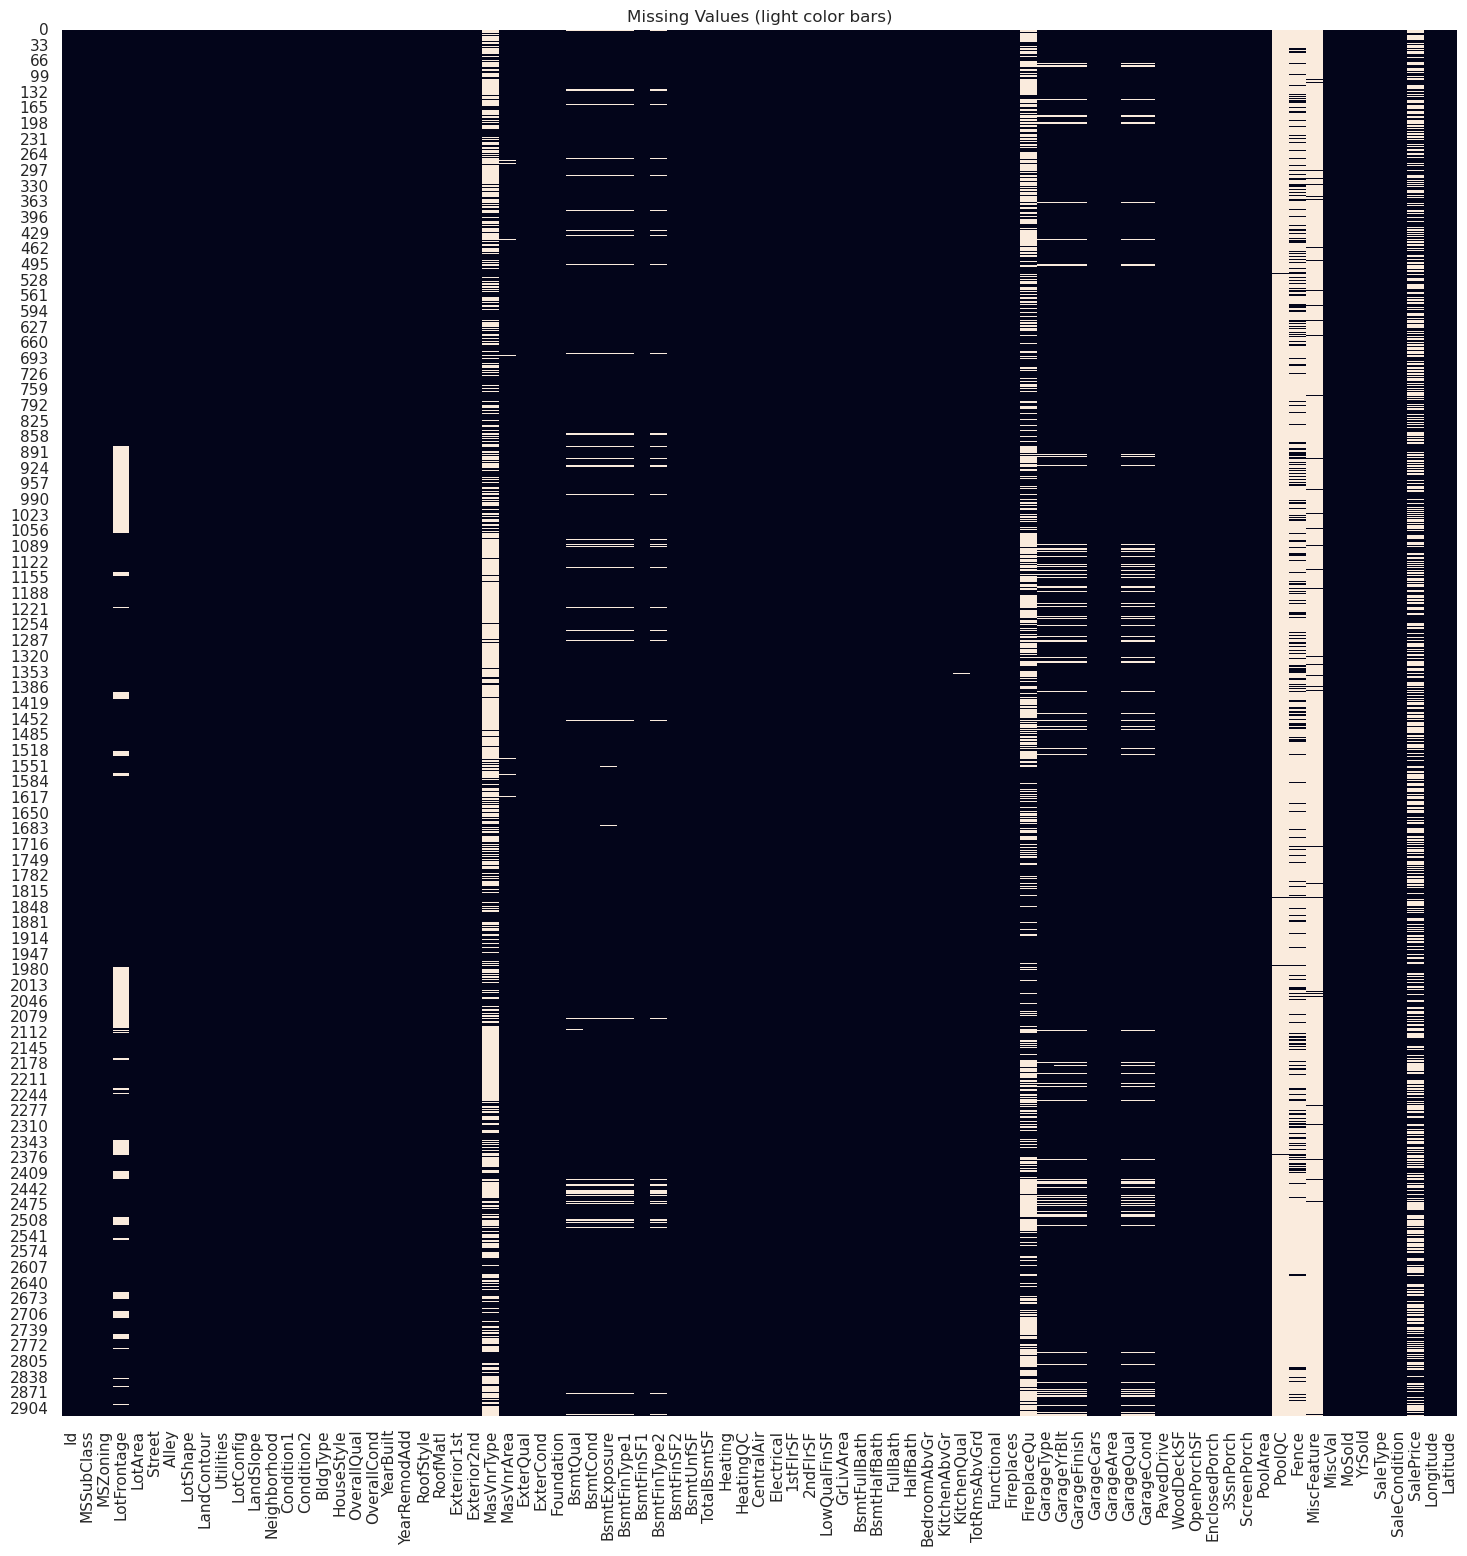

In [10]:
# Create a mask for missing values
missing_mask = df.isnull()
plt.figure(figsize=(18, 18))
sns.heatmap(missing_mask, cbar=False)
plt.title('Missing Values (light color bars)')
plt.show()

In [11]:
with pd.option_context('display.max_rows', None):
    print(f'Unique values by fetature in train dataset:\n{df_train.nunique().sort_values()}')

Unique values by fetature in train dataset:
Utilities           2
CentralAir          2
Street              2
PavedDrive          3
BsmtHalfBath        3
MasVnrType          3
HalfBath            3
LandSlope           3
Alley               3
PoolQC              3
GarageFinish        3
FullBath            4
KitchenQual         4
Fireplaces          4
LandContour         4
KitchenAbvGr        4
ExterQual           4
BsmtExposure        4
BsmtFullBath        4
BsmtCond            4
BsmtQual            4
LotShape            4
Fence               4
MiscFeature         4
YrSold              5
MSZoning            5
ExterCond           5
Electrical          5
HeatingQC           5
GarageQual          5
GarageCond          5
FireplaceQu         5
GarageCars          5
BldgType            5
LotConfig           5
BsmtFinType2        6
Heating             6
BsmtFinType1        6
Foundation          6
SaleCondition       6
RoofStyle           6
GarageType          6
Functional          7
HouseStyle

In [12]:
# check the categoric features
n_unique_values = 16

for i, value in enumerate(df.nunique()):
    if value <= n_unique_values:
        print(df_train[df_train.nunique().index[i]].value_counts())

print(df_train['Neighborhood'].value_counts())

MSSubClass
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: count, dtype: int64
MSZoning
rl    1151
rm     218
fv      65
rh      16
c       10
Name: count, dtype: int64
Street
pave    1454
grvl       6
Name: count, dtype: int64
Alley
no_alley_access    1369
grvl                 50
pave                 41
Name: count, dtype: int64
LotShape
reg    925
ir1    484
ir2     41
ir3     10
Name: count, dtype: int64
LandContour
lvl    1311
bnk      63
hls      50
low      36
Name: count, dtype: int64
Utilities
allpub    1459
nosewa       1
Name: count, dtype: int64
LotConfig
inside     1052
corner      263
culdsac      94
fr2          47
fr3           4
Name: count, dtype: int64
LandSlope
gtl    1382
mod      65
sev      13
Name: count, dtype: int64
Condition1
norm      1260
feedr       81
artery      48
rran        26
posn        19
rrae        11
posa         8
rrnn      

## <span style="color: red">Thoughts</span>

- Consider which categories/categorical variables have meaningful sample sizes.
- Several variables have missing values. Evaluate each case individually to determine how to proceed.
- How to deal with YearRemodAdd: Make the delta between construction year and remodel date.
- BsmtFinType2 has an strange encoding
- MSSubClass has redundancy with YearBuilt
- MSSubClass has redundancy with HouseStyle
- 'OverallQual' 'OverallCond' may be redundant 
- 'ExterQual', 'ExterCond' may be redundant
- 'GarageQual', 'GarageCond' may be redundant

## <span style="color: red">Actions</span>

### drop :
- drop categorical features that have no representative second category (<15) in train data ('Street', 'Utilities', 'RoofMatl', 'Condition2', 'PoolQC')
- need to correct the class cmentbd in 'Exterior2nd'. It should be cemntbd


In [14]:
#drop categorical features
df = df.drop(['Street', 'Utilities', 'RoofMatl','Condition2','PoolQC'], axis=1)

df.loc[df['Exterior2nd'] == 'cmentbd', 'Exterior2nd'] = 'cemntbd'

# Treating Missing Values <a name="missing"></a>

## <span style="color: red">Thoughts</span>
- at least in some case the NaNs are actually the class NA
- will start with cases with less missing values
- several features with a single missing value are present in the test dataset and must be addressed. I cannot simply exclude them from the dataset.

## <span style="color: red">Actions</span>
- throughout the search, I will impute values using the median for numeric features. For categorical features, I will treat NaNs as the 'unknown' category, following AutoGluon's procedure.

## <span style="color: red">Remarks</span>
- my NaN treatment improves the model result in comparison with AutoGluons approach 

In [17]:
print("\nColumns with null values (%):\n", df.isnull().mean()[lambda x: x > 0].sort_values(ascending=False) * 100)


Columns with null values (%):
 MiscFeature     96.368619
Fence           80.438506
MasVnrType      60.465913
SalePrice       49.982871
FireplaceQu     48.646797
LotFrontage     16.649538
GarageYrBlt      5.447071
GarageQual       5.447071
GarageCond       5.447071
GarageFinish     5.447071
GarageType       5.378554
BsmtExposure     2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtCond         2.706406
BsmtFinType1     2.706406
MasVnrArea       0.787941
KitchenQual      0.034258
Electrical       0.034258
dtype: float64


In [18]:
feature = 'Electrical'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
2287  1380          80       rl         73.0     9735  no_alley_access   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
2287      reg         lvl    inside       gtl       timber       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
2287     1fam       slvl            5            5       2006          2007   

     RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
2287     gable     vinylsd     vinylsd        NaN         0.0        ta   

     ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
2287        ta      pconc       gd       ta           no          unf   

      BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  \
2287         0.0          unf         0.0      384.0        384.0    gasa   

     HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
2287        gd          y        NaN       754       640             0   

      GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
2287       1394           0.0           0.0         2         1             3   

      KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces  \
2287             1          gd             7        typ           0   

     FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea  \
2287         NaN    builtin       2007.0          fin         2.0       400.0   

     GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
2287         ta         ta          y         100            0              0   

      3SsnPorch  ScreenPorch  PoolArea Fence MiscFeature  MiscVal  MoSold  \
2287          0            0         0   NaN         NaN        0       5   

      YrSold SaleType SaleCondition  SalePrice  Longitude   Latitude  
2287    2008       wd        normal   167500.0 -93.649475  41.993751

In [19]:
df.loc[df[feature].isnull(),feature] = 'unknown'
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [20]:
feature = 'KitchenQual'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
1355  1556          50       rl         72.0    10632  no_alley_access   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
1355      ir1         lvl    inside       gtl      clearcr       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
1355     1fam     1.5fin            5            3       1917          1950   

     RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
1355     gable     wd sdng     wd sdng        NaN         0.0        ta   

     ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
1355        ta     brktil       gd       fa           no          unf   

      BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  \
1355         0.0          unf         0.0      689.0        689.0    gasa   

     HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
1355        gd          n      sbrkr       725       499             0   

      GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
1355       1224           0.0           0.0         1         1             3   

      KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces  \
1355             1         NaN             6        mod           0   

     FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea  \
1355         NaN     detchd       1917.0          unf         1.0       180.0   

     GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
1355         fa         fa          n           0            0            248   

      3SsnPorch  ScreenPorch  PoolArea Fence MiscFeature  MiscVal  MoSold  \
1355          0            0         0   NaN         NaN        0       1   

      YrSold SaleType SaleCondition  SalePrice  Longitude   Latitude  
1355    2010      cod        normal        NaN -93.658265  42.028256

In [21]:
df.loc[df[feature].isnull(),feature] = 'unknown'
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [22]:
feature = 'MasVnrArea'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
33    1707          20       fv         90.0     7993  no_alley_access   
35     974          20       fv         95.0    11639  no_alley_access   
65    2687          20       rl         49.0    15218  no_alley_access   
274    937          20       rl         67.0    10083  no_alley_access   
281   2593          20       rl         68.0     8298  no_alley_access   
441   2863          20       rl         75.0     8050  no_alley_access   
646   2341          20       rl         85.0     9965  no_alley_access   
685   2005          20       rl         87.0    10037  no_alley_access   
815   1244          20       rl        107.0    13891  no_alley_access   
1051   530          20       rl          NaN    32668  no_alley_access   
1534   651          60       fv         65.0     8125  no_alley_access   
1564  2350          60       fv        112.0    12217  no_alley_access   
1568  2042          60       fv          NaN     7500  no_alley_access   
1614  2312          60       rl         59.0    15810  no_alley_access   
1706  1883          60       rl         70.0     8749  no_alley_access   
1762  1279          60       rl         75.0     9473  no_alley_access   
1931  2658          60       rl        103.0    12867  no_alley_access   
1977  1993          60       rl          NaN     7750  no_alley_access   
1979   235          60       rl          NaN     7851  no_alley_access   
2062  1692          60       rl          NaN    12891  no_alley_access   
2356  2326          80       rl          NaN    11950  no_alley_access   
2531  2369         120       fv         30.0     5330             pave   
2535   978         120       fv         35.0     4274             pave   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
33        ir1         lvl    inside       gtl      somerst       norm   
35        reg         lvl    corner       gtl      somerst       norm   
65        ir1         lvl   culdsac       gtl      somerst       rran   
274       reg         lvl    inside       gtl      sawyerw       norm   
281       ir1         hls    inside       gtl       timber       norm   
441       reg         lvl    inside       gtl      edwards       norm   
646       reg         lvl       fr2       gtl      somerst      feedr   
685       reg         lvl    corner       gtl      somerst      feedr   
815       reg         lvl    inside       gtl      nridght       norm   
1051      ir1         lvl   culdsac       gtl      crawfor       norm   
1534      reg         lvl    inside       gtl      somerst       norm   
1564      ir1         lvl    inside       gtl      somerst       norm   
1568      reg         lvl    inside       gtl      somerst       norm   
1614      ir1         lvl    inside       gtl      gilbert       rran   
1706      reg         lvl    inside       gtl      collgcr       norm   
1762      reg         lvl    inside       gtl      collgcr       norm   
1931      ir1         lvl    corner       gtl      nridght       norm   
1977      reg         lvl    inside       gtl      gilbert       rran   
1979      reg         lvl    inside       gtl      gilbert       norm   
2062      ir1         lvl    corner       gtl      gilbert       norm   
2356      ir1         lvl    corner       gtl      gilbert       norm   
2531      ir2         lvl    inside       gtl      somerst       norm   
2535      ir1         lvl    inside       gtl      somerst       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
33       1fam     1story            7            5       2008          2009   
35       1fam     1story            7            5       2007          2008   
65       1fam     1story            8            5       2006          2006   
274      1fam     1story            7            5       2003          2003   
281      1fam     1story            8            5       2006          2007   
441 

In [23]:
df.groupby('Exterior1st')['MasVnrArea'].count()
#searching for a relationship between potential related features
pd.crosstab( pd.cut(df['MasVnrArea'], bins=10),df['Exterior1st'])[['vinylsd', 'wd sdng', 'cemntbd', 'wdshing']]

Exterior1st       vinylsd  wd sdng  cemntbd  wdshing
MasVnrArea                                          
(-1.6, 160.0]         678      361       76       46
(160.0, 320.0]        205       27       29        8
(320.0, 480.0]         64       11        9        0
(480.0, 640.0]         32        5        1        1
(640.0, 800.0]         16        4        4        0
(800.0, 960.0]          6        1        2        0
(960.0, 1120.0]         5        1        1        0
(1120.0, 1280.0]        0        0        1        0
(1280.0, 1440.0]        0        0        0        0
(1440.0, 1600.0]        1        0        0        0

In [24]:
#pd.crosstab( pd.cut(df['MasVnrArea'], bins=10),df['Foundation'])
#pd.crosstab( pd.cut(df['MasVnrArea'], bins=10),df['RoofStyle'])
#pd.crosstab( pd.cut(df['MasVnrArea'], bins=10),df['LotConfig'])
#pd.crosstab( pd.cut(df['MasVnrArea'], bins=10),df['MSZoning'])

df.loc[df[feature].isnull(),feature] = df[feature].median()
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [25]:
feature = 'BsmtCond'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
0     2217          20        a         80.0    14584  no_alley_access   
1     2905          20        a        125.0    31250  no_alley_access   
69     534          20       rl         50.0     5000  no_alley_access   
124     91          20       rl         60.0     7200  no_alley_access   
125    647          20       rl         60.0     7200  no_alley_access   
...    ...         ...      ...          ...      ...              ...   
2511  2388          90       rl          NaN    10899  no_alley_access   
2522  2703          90       rm         68.0     8927  no_alley_access   
2523  1217          90       rm         68.0     8930  no_alley_access   
2871   521         190       rl         60.0    10800             grvl   
2915   706         190       rm         70.0     5600  no_alley_access   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
0         reg         low    inside       mod       idotrr       norm   
1         reg         lvl    inside       gtl      mitchel     artery   
69        reg         low    inside       mod      brkside       norm   
124       reg         lvl    inside       gtl        names       norm   
125       reg         lvl    inside       gtl        names       norm   
...       ...         ...       ...       ...          ...        ...   
2511      ir1         lvl    inside       gtl        names       norm   
2522      reg         lvl    inside       gtl       sawyer       rrae   
2523      reg         lvl    inside       gtl       sawyer       rrae   
2871      reg         lvl    inside       gtl      oldtown       norm   
2915      reg         lvl    inside       gtl       idotrr       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0        1fam     1story            1            5       1952          1952   
1        1fam     1story            1            3       1951          1951   
69       1fam     1story            1            3       1946          1950   
124      1fam     1story            4            5       1950          1950   
125      1fam     1story            5            5       1950          1950   
...       ...        ...          ...          ...        ...           ...   
2511   duplex     1story            4            5       1964          1964   
2522   duplex     1.5fin            6            6       1977          1977   
2523   duplex     1.5fin            6            5       1978          1978   
2871   2fmcon     2story            4            7       1900          2000   
2915   2fmcon     2story            4            5       1930          1950   

     RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0        gable     asbshng     vinylsd        NaN         0.0        fa   
1        gable      cblock     vinylsd        NaN         0.0        ta   
69       gable     vinylsd     vinylsd        NaN         0.0        fa   
124      gable     brkface     wd sdng        NaN         0.0        ta   
125        hip     metalsd     metalsd        NaN         0.0        ta   
...        ...         ...         ...        ...         ...       ...   
2511     gable     hdboard     hdboard        NaN         0.0        ta   
2522     gable     vinylsd     vinylsd        NaN         0.0        ta   
2523     gable     vinylsd     vinylsd        NaN         0.0        ta   
2871     gable     metalsd     metalsd        NaN         0.0        ta   
2915       hip     vinylsd     wd shng        NaN         0.0        fa   

     ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
0           po       slab      NaN      NaN          NaN          NaN   
1           fa     cblock      NaN      NaN          NaN          NaN   
69          fa       slab      NaN      NaN          NaN          NaN   
124         ta       slab      NaN      NaN          NaN          NaN   
125         ta     cblock  

In [26]:
df.loc[df[feature].isnull(),'BsmtFinSF1'].sum()

0.0

In [27]:
df.loc[(df[feature].isnull()) & (df['BsmtFinSF1'] == 0), feature] = 'no_basement'
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [28]:
feature = 'BsmtFinType1'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
0     2217          20        a         80.0    14584  no_alley_access   
1     2905          20        a        125.0    31250  no_alley_access   
69     534          20       rl         50.0     5000  no_alley_access   
124     91          20       rl         60.0     7200  no_alley_access   
125    647          20       rl         60.0     7200  no_alley_access   
...    ...         ...      ...          ...      ...              ...   
2511  2388          90       rl          NaN    10899  no_alley_access   
2522  2703          90       rm         68.0     8927  no_alley_access   
2523  1217          90       rm         68.0     8930  no_alley_access   
2871   521         190       rl         60.0    10800             grvl   
2915   706         190       rm         70.0     5600  no_alley_access   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
0         reg         low    inside       mod       idotrr       norm   
1         reg         lvl    inside       gtl      mitchel     artery   
69        reg         low    inside       mod      brkside       norm   
124       reg         lvl    inside       gtl        names       norm   
125       reg         lvl    inside       gtl        names       norm   
...       ...         ...       ...       ...          ...        ...   
2511      ir1         lvl    inside       gtl        names       norm   
2522      reg         lvl    inside       gtl       sawyer       rrae   
2523      reg         lvl    inside       gtl       sawyer       rrae   
2871      reg         lvl    inside       gtl      oldtown       norm   
2915      reg         lvl    inside       gtl       idotrr       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0        1fam     1story            1            5       1952          1952   
1        1fam     1story            1            3       1951          1951   
69       1fam     1story            1            3       1946          1950   
124      1fam     1story            4            5       1950          1950   
125      1fam     1story            5            5       1950          1950   
...       ...        ...          ...          ...        ...           ...   
2511   duplex     1story            4            5       1964          1964   
2522   duplex     1.5fin            6            6       1977          1977   
2523   duplex     1.5fin            6            5       1978          1978   
2871   2fmcon     2story            4            7       1900          2000   
2915   2fmcon     2story            4            5       1930          1950   

     RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0        gable     asbshng     vinylsd        NaN         0.0        fa   
1        gable      cblock     vinylsd        NaN         0.0        ta   
69       gable     vinylsd     vinylsd        NaN         0.0        fa   
124      gable     brkface     wd sdng        NaN         0.0        ta   
125        hip     metalsd     metalsd        NaN         0.0        ta   
...        ...         ...         ...        ...         ...       ...   
2511     gable     hdboard     hdboard        NaN         0.0        ta   
2522     gable     vinylsd     vinylsd        NaN         0.0        ta   
2523     gable     vinylsd     vinylsd        NaN         0.0        ta   
2871     gable     metalsd     metalsd        NaN         0.0        ta   
2915       hip     vinylsd     wd shng        NaN         0.0        fa   

     ExterCond Foundation BsmtQual     BsmtCond BsmtExposure BsmtFinType1  \
0           po       slab      NaN  no_basement          NaN          NaN   
1           fa     cblock      NaN  no_basement          NaN          NaN   
69          fa       slab      NaN  no_basement          NaN          NaN   
124         ta       slab      NaN  no_basement          NaN          NaN   
125    

In [29]:
df.loc[df[feature].isnull(),'BsmtFinSF1'].sum()

0.0

In [30]:
df.loc[df[feature].isnull(),feature] = 'no_basement'
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [31]:
feature = 'BsmtFinType2'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
0     2217          20        a         80.0    14584  no_alley_access   
1     2905          20        a        125.0    31250  no_alley_access   
69     534          20       rl         50.0     5000  no_alley_access   
124     91          20       rl         60.0     7200  no_alley_access   
125    647          20       rl         60.0     7200  no_alley_access   
...    ...         ...      ...          ...      ...              ...   
2511  2388          90       rl          NaN    10899  no_alley_access   
2522  2703          90       rm         68.0     8927  no_alley_access   
2523  1217          90       rm         68.0     8930  no_alley_access   
2871   521         190       rl         60.0    10800             grvl   
2915   706         190       rm         70.0     5600  no_alley_access   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
0         reg         low    inside       mod       idotrr       norm   
1         reg         lvl    inside       gtl      mitchel     artery   
69        reg         low    inside       mod      brkside       norm   
124       reg         lvl    inside       gtl        names       norm   
125       reg         lvl    inside       gtl        names       norm   
...       ...         ...       ...       ...          ...        ...   
2511      ir1         lvl    inside       gtl        names       norm   
2522      reg         lvl    inside       gtl       sawyer       rrae   
2523      reg         lvl    inside       gtl       sawyer       rrae   
2871      reg         lvl    inside       gtl      oldtown       norm   
2915      reg         lvl    inside       gtl       idotrr       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0        1fam     1story            1            5       1952          1952   
1        1fam     1story            1            3       1951          1951   
69       1fam     1story            1            3       1946          1950   
124      1fam     1story            4            5       1950          1950   
125      1fam     1story            5            5       1950          1950   
...       ...        ...          ...          ...        ...           ...   
2511   duplex     1story            4            5       1964          1964   
2522   duplex     1.5fin            6            6       1977          1977   
2523   duplex     1.5fin            6            5       1978          1978   
2871   2fmcon     2story            4            7       1900          2000   
2915   2fmcon     2story            4            5       1930          1950   

     RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0        gable     asbshng     vinylsd        NaN         0.0        fa   
1        gable      cblock     vinylsd        NaN         0.0        ta   
69       gable     vinylsd     vinylsd        NaN         0.0        fa   
124      gable     brkface     wd sdng        NaN         0.0        ta   
125        hip     metalsd     metalsd        NaN         0.0        ta   
...        ...         ...         ...        ...         ...       ...   
2511     gable     hdboard     hdboard        NaN         0.0        ta   
2522     gable     vinylsd     vinylsd        NaN         0.0        ta   
2523     gable     vinylsd     vinylsd        NaN         0.0        ta   
2871     gable     metalsd     metalsd        NaN         0.0        ta   
2915       hip     vinylsd     wd shng        NaN         0.0        fa   

     ExterCond Foundation BsmtQual     BsmtCond BsmtExposure BsmtFinType1  \
0           po       slab      NaN  no_basement          NaN  no_basement   
1           fa     cblock      NaN  no_basement          NaN  no_basement   
69          fa       slab      NaN  no_basement          NaN  no_basement   
124         ta       slab      NaN  no_basement          NaN  no_basement   
125    

In [32]:
df.loc[df[feature].isnull(),'BsmtFinSF1'].sum()

1124.0

In [33]:
df.loc[(df[feature].isnull()) & (df['BsmtFinSF1'] == 0), feature] = 'no_basement'
df.loc[332, feature] = 'no_basement'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley LotShape  \
657  333          20       rl         85.0    10655  no_alley_access      ir1   

    LandContour LotConfig LandSlope Neighborhood Condition1 BldgType  \
657         lvl    inside       gtl      nridght       norm     1fam   

    HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle  \
657     1story            8            5       2003          2004     gable   

    Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond  \
657     vinylsd     vinylsd    brkface       296.0        gd        ta   

    Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1  \
657      pconc       gd       ta           no          glq      1124.0   

    BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC  \
657          NaN       479.0     1603.0       3206.0    gasa        ex   

    CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
657          y      sbrkr      1629         0             0       1629   

     BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
657           1.0           0.0         2         0             3   

     KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces  \
657             1          gd             7        typ           1   

    FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea  \
657          gd     attchd       2003.0          rfn         3.0       880.0   

    GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
657         ta         ta          y           0            0              0   

     3SsnPorch  ScreenPorch  PoolArea Fence MiscFeature  MiscVal  MoSold  \
657          0            0         0   NaN         NaN        0      10   

     YrSold SaleType SaleCondition  SalePrice  Longitude   Latitude  
657    2009       wd        normal   284000.0 -93.654127  42.059912

In [34]:
df.loc[(df[feature].isnull()), feature] = 'unknown'
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [35]:
feature = 'BsmtQual'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
0     2217          20        a         80.0    14584  no_alley_access   
1     2905          20        a        125.0    31250  no_alley_access   
69     534          20       rl         50.0     5000  no_alley_access   
124     91          20       rl         60.0     7200  no_alley_access   
125    647          20       rl         60.0     7200  no_alley_access   
...    ...         ...      ...          ...      ...              ...   
2511  2388          90       rl          NaN    10899  no_alley_access   
2522  2703          90       rm         68.0     8927  no_alley_access   
2523  1217          90       rm         68.0     8930  no_alley_access   
2871   521         190       rl         60.0    10800             grvl   
2915   706         190       rm         70.0     5600  no_alley_access   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
0         reg         low    inside       mod       idotrr       norm   
1         reg         lvl    inside       gtl      mitchel     artery   
69        reg         low    inside       mod      brkside       norm   
124       reg         lvl    inside       gtl        names       norm   
125       reg         lvl    inside       gtl        names       norm   
...       ...         ...       ...       ...          ...        ...   
2511      ir1         lvl    inside       gtl        names       norm   
2522      reg         lvl    inside       gtl       sawyer       rrae   
2523      reg         lvl    inside       gtl       sawyer       rrae   
2871      reg         lvl    inside       gtl      oldtown       norm   
2915      reg         lvl    inside       gtl       idotrr       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0        1fam     1story            1            5       1952          1952   
1        1fam     1story            1            3       1951          1951   
69       1fam     1story            1            3       1946          1950   
124      1fam     1story            4            5       1950          1950   
125      1fam     1story            5            5       1950          1950   
...       ...        ...          ...          ...        ...           ...   
2511   duplex     1story            4            5       1964          1964   
2522   duplex     1.5fin            6            6       1977          1977   
2523   duplex     1.5fin            6            5       1978          1978   
2871   2fmcon     2story            4            7       1900          2000   
2915   2fmcon     2story            4            5       1930          1950   

     RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0        gable     asbshng     vinylsd        NaN         0.0        fa   
1        gable      cblock     vinylsd        NaN         0.0        ta   
69       gable     vinylsd     vinylsd        NaN         0.0        fa   
124      gable     brkface     wd sdng        NaN         0.0        ta   
125        hip     metalsd     metalsd        NaN         0.0        ta   
...        ...         ...         ...        ...         ...       ...   
2511     gable     hdboard     hdboard        NaN         0.0        ta   
2522     gable     vinylsd     vinylsd        NaN         0.0        ta   
2523     gable     vinylsd     vinylsd        NaN         0.0        ta   
2871     gable     metalsd     metalsd        NaN         0.0        ta   
2915       hip     vinylsd     wd shng        NaN         0.0        fa   

     ExterCond Foundation BsmtQual     BsmtCond BsmtExposure BsmtFinType1  \
0           po       slab      NaN  no_basement          NaN  no_basement   
1           fa     cblock      NaN  no_basement          NaN  no_basement   
69          fa       slab      NaN  no_basement          NaN  no_basement   
124         ta       slab      NaN  no_basement          NaN  no_basement   
125    

In [36]:
df.loc[df[feature].isnull(),'BsmtFinSF1'].sum()

0.0

In [37]:
df.loc[df[feature].isnull(),feature] = 'no_basement'
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [38]:
feature = 'BsmtExposure'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
0     2217          20        a         80.0    14584  no_alley_access   
1     2905          20        a        125.0    31250  no_alley_access   
69     534          20       rl         50.0     5000  no_alley_access   
124     91          20       rl         60.0     7200  no_alley_access   
125    647          20       rl         60.0     7200  no_alley_access   
...    ...         ...      ...          ...      ...              ...   
2511  2388          90       rl          NaN    10899  no_alley_access   
2522  2703          90       rm         68.0     8927  no_alley_access   
2523  1217          90       rm         68.0     8930  no_alley_access   
2871   521         190       rl         60.0    10800             grvl   
2915   706         190       rm         70.0     5600  no_alley_access   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
0         reg         low    inside       mod       idotrr       norm   
1         reg         lvl    inside       gtl      mitchel     artery   
69        reg         low    inside       mod      brkside       norm   
124       reg         lvl    inside       gtl        names       norm   
125       reg         lvl    inside       gtl        names       norm   
...       ...         ...       ...       ...          ...        ...   
2511      ir1         lvl    inside       gtl        names       norm   
2522      reg         lvl    inside       gtl       sawyer       rrae   
2523      reg         lvl    inside       gtl       sawyer       rrae   
2871      reg         lvl    inside       gtl      oldtown       norm   
2915      reg         lvl    inside       gtl       idotrr       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0        1fam     1story            1            5       1952          1952   
1        1fam     1story            1            3       1951          1951   
69       1fam     1story            1            3       1946          1950   
124      1fam     1story            4            5       1950          1950   
125      1fam     1story            5            5       1950          1950   
...       ...        ...          ...          ...        ...           ...   
2511   duplex     1story            4            5       1964          1964   
2522   duplex     1.5fin            6            6       1977          1977   
2523   duplex     1.5fin            6            5       1978          1978   
2871   2fmcon     2story            4            7       1900          2000   
2915   2fmcon     2story            4            5       1930          1950   

     RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0        gable     asbshng     vinylsd        NaN         0.0        fa   
1        gable      cblock     vinylsd        NaN         0.0        ta   
69       gable     vinylsd     vinylsd        NaN         0.0        fa   
124      gable     brkface     wd sdng        NaN         0.0        ta   
125        hip     metalsd     metalsd        NaN         0.0        ta   
...        ...         ...         ...        ...         ...       ...   
2511     gable     hdboard     hdboard        NaN         0.0        ta   
2522     gable     vinylsd     vinylsd        NaN         0.0        ta   
2523     gable     vinylsd     vinylsd        NaN         0.0        ta   
2871     gable     metalsd     metalsd        NaN         0.0        ta   
2915       hip     vinylsd     wd shng        NaN         0.0        fa   

     ExterCond Foundation     BsmtQual     BsmtCond BsmtExposure BsmtFinType1  \
0           po       slab  no_basement  no_basement          NaN  no_basement   
1           fa     cblock  no_basement  no_basement          NaN  no_basement   
69          fa       slab  no_basement  no_basement          NaN  no_basement   
124         ta       slab  no_basement  no_basement          NaN  no

In [39]:
df.loc[df[feature].isnull(),feature] = 'no_basement'
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [40]:
feature = 'GarageType'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
69     534          20       rl         50.0     5000  no_alley_access   
70    2399          20       rl         50.0     5000  no_alley_access   
74     961          20       rl         50.0     7207  no_alley_access   
77    1124          20       rl         50.0     9405  no_alley_access   
136     90          20       rl         60.0     8070  no_alley_access   
...    ...         ...      ...          ...      ...              ...   
2906  2136         190       rm         60.0    10320             grvl   
2910  1811         190       rm         63.0     7627  no_alley_access   
2911  2091         190       rm         63.0    11426             grvl   
2915   706         190       rm         70.0     5600  no_alley_access   
2918  1540         190       rm        100.0     9045  no_alley_access   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
69        reg         low    inside       mod      brkside       norm   
70        reg         lvl    inside       gtl      brkside       norm   
74        ir1         lvl    inside       gtl      brkside       norm   
77        reg         lvl    inside       gtl      edwards       norm   
136       reg         lvl    inside       gtl      collgcr       norm   
...       ...         ...       ...       ...          ...        ...   
2906      reg         lvl    inside       gtl       idotrr       norm   
2910      reg         lvl    corner       gtl      oldtown     artery   
2911      reg         lvl    inside       gtl      oldtown       norm   
2915      reg         lvl    inside       gtl       idotrr       norm   
2918      reg         lvl    inside       gtl      oldtown       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
69       1fam     1story            1            3       1946          1950   
70       1fam     1story            3            3       1946          1950   
74       1fam     1story            5            7       1958          2008   
77       1fam     1story            5            9       1947          2008   
136      1fam     1story            4            5       1994          1995   
...       ...        ...          ...          ...        ...           ...   
2906   2fmcon     2story            3            3       1915          1950   
2910   2fmcon     2story            4            6       1920          1950   
2911   2fmcon     1.5fin            4            6       1910          1996   
2915   2fmcon     2story            4            5       1930          1950   
2918   2fmcon     2story            5            3       1910          1950   

     RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
69       gable     vinylsd     vinylsd        NaN         0.0        fa   
70       gable     wdshing     wd shng        NaN         0.0        fa   
74       gable     wd sdng     plywood        NaN         0.0        ta   
77         hip     vinylsd     vinylsd        NaN         0.0        ta   
136      gable     vinylsd     vinylsd        NaN         0.0        ta   
...        ...         ...         ...        ...         ...       ...   
2906     gable     asphshn     asphshn        NaN         0.0        fa   
2910     gable     asbshng     asbshng        NaN         0.0        fa   
2911     gable     wd sdng     wd sdng        NaN         0.0        ta   
2915       hip     vinylsd     wd shng        NaN         0.0        fa   
2918     gable     metalsd     metalsd        NaN         0.0        ta   

     ExterCond Foundation     BsmtQual     BsmtCond BsmtExposure BsmtFinType1  \
69          fa       slab  no_basement  no_basement  no_basement  no_basement   
70          fa     cblock           fa           fa           no          lwq   
74          gd     cblock           ta           ta           gd          blq   
77          ex     cblock           ta           ta           no    

In [41]:
df.loc[df[feature].isnull(),'GarageArea'].sum()

0.0

In [42]:
df.loc[df[feature].isnull(),feature] = 'no_garage'
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [43]:
feature = 'GarageCond'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
69     534          20       rl         50.0     5000  no_alley_access   
70    2399          20       rl         50.0     5000  no_alley_access   
74     961          20       rl         50.0     7207  no_alley_access   
77    1124          20       rl         50.0     9405  no_alley_access   
136     90          20       rl         60.0     8070  no_alley_access   
...    ...         ...      ...          ...      ...              ...   
2906  2136         190       rm         60.0    10320             grvl   
2910  1811         190       rm         63.0     7627  no_alley_access   
2911  2091         190       rm         63.0    11426             grvl   
2915   706         190       rm         70.0     5600  no_alley_access   
2918  1540         190       rm        100.0     9045  no_alley_access   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
69        reg         low    inside       mod      brkside       norm   
70        reg         lvl    inside       gtl      brkside       norm   
74        ir1         lvl    inside       gtl      brkside       norm   
77        reg         lvl    inside       gtl      edwards       norm   
136       reg         lvl    inside       gtl      collgcr       norm   
...       ...         ...       ...       ...          ...        ...   
2906      reg         lvl    inside       gtl       idotrr       norm   
2910      reg         lvl    corner       gtl      oldtown     artery   
2911      reg         lvl    inside       gtl      oldtown       norm   
2915      reg         lvl    inside       gtl       idotrr       norm   
2918      reg         lvl    inside       gtl      oldtown       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
69       1fam     1story            1            3       1946          1950   
70       1fam     1story            3            3       1946          1950   
74       1fam     1story            5            7       1958          2008   
77       1fam     1story            5            9       1947          2008   
136      1fam     1story            4            5       1994          1995   
...       ...        ...          ...          ...        ...           ...   
2906   2fmcon     2story            3            3       1915          1950   
2910   2fmcon     2story            4            6       1920          1950   
2911   2fmcon     1.5fin            4            6       1910          1996   
2915   2fmcon     2story            4            5       1930          1950   
2918   2fmcon     2story            5            3       1910          1950   

     RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
69       gable     vinylsd     vinylsd        NaN         0.0        fa   
70       gable     wdshing     wd shng        NaN         0.0        fa   
74       gable     wd sdng     plywood        NaN         0.0        ta   
77         hip     vinylsd     vinylsd        NaN         0.0        ta   
136      gable     vinylsd     vinylsd        NaN         0.0        ta   
...        ...         ...         ...        ...         ...       ...   
2906     gable     asphshn     asphshn        NaN         0.0        fa   
2910     gable     asbshng     asbshng        NaN         0.0        fa   
2911     gable     wd sdng     wd sdng        NaN         0.0        ta   
2915       hip     vinylsd     wd shng        NaN         0.0        fa   
2918     gable     metalsd     metalsd        NaN         0.0        ta   

     ExterCond Foundation     BsmtQual     BsmtCond BsmtExposure BsmtFinType1  \
69          fa       slab  no_basement  no_basement  no_basement  no_basement   
70          fa     cblock           fa           fa           no          lwq   
74          gd     cblock           ta           ta           gd          blq   
77          ex     cblock           ta           ta           no    

In [44]:
df.loc[(df[feature].isnull()) & (df['GarageArea']!= 0)]
df.loc[2101,feature] = 'unknown'

In [45]:
df.loc[df[feature].isnull(),feature] = 'no_garage'
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [46]:
feature = 'GarageQual'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
69     534          20       rl         50.0     5000  no_alley_access   
70    2399          20       rl         50.0     5000  no_alley_access   
74     961          20       rl         50.0     7207  no_alley_access   
77    1124          20       rl         50.0     9405  no_alley_access   
136     90          20       rl         60.0     8070  no_alley_access   
...    ...         ...      ...          ...      ...              ...   
2906  2136         190       rm         60.0    10320             grvl   
2910  1811         190       rm         63.0     7627  no_alley_access   
2911  2091         190       rm         63.0    11426             grvl   
2915   706         190       rm         70.0     5600  no_alley_access   
2918  1540         190       rm        100.0     9045  no_alley_access   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
69        reg         low    inside       mod      brkside       norm   
70        reg         lvl    inside       gtl      brkside       norm   
74        ir1         lvl    inside       gtl      brkside       norm   
77        reg         lvl    inside       gtl      edwards       norm   
136       reg         lvl    inside       gtl      collgcr       norm   
...       ...         ...       ...       ...          ...        ...   
2906      reg         lvl    inside       gtl       idotrr       norm   
2910      reg         lvl    corner       gtl      oldtown     artery   
2911      reg         lvl    inside       gtl      oldtown       norm   
2915      reg         lvl    inside       gtl       idotrr       norm   
2918      reg         lvl    inside       gtl      oldtown       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
69       1fam     1story            1            3       1946          1950   
70       1fam     1story            3            3       1946          1950   
74       1fam     1story            5            7       1958          2008   
77       1fam     1story            5            9       1947          2008   
136      1fam     1story            4            5       1994          1995   
...       ...        ...          ...          ...        ...           ...   
2906   2fmcon     2story            3            3       1915          1950   
2910   2fmcon     2story            4            6       1920          1950   
2911   2fmcon     1.5fin            4            6       1910          1996   
2915   2fmcon     2story            4            5       1930          1950   
2918   2fmcon     2story            5            3       1910          1950   

     RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
69       gable     vinylsd     vinylsd        NaN         0.0        fa   
70       gable     wdshing     wd shng        NaN         0.0        fa   
74       gable     wd sdng     plywood        NaN         0.0        ta   
77         hip     vinylsd     vinylsd        NaN         0.0        ta   
136      gable     vinylsd     vinylsd        NaN         0.0        ta   
...        ...         ...         ...        ...         ...       ...   
2906     gable     asphshn     asphshn        NaN         0.0        fa   
2910     gable     asbshng     asbshng        NaN         0.0        fa   
2911     gable     wd sdng     wd sdng        NaN         0.0        ta   
2915       hip     vinylsd     wd shng        NaN         0.0        fa   
2918     gable     metalsd     metalsd        NaN         0.0        ta   

     ExterCond Foundation     BsmtQual     BsmtCond BsmtExposure BsmtFinType1  \
69          fa       slab  no_basement  no_basement  no_basement  no_basement   
70          fa     cblock           fa           fa           no          lwq   
74          gd     cblock           ta           ta           gd          blq   
77          ex     cblock           ta           ta           no    

In [47]:
df.loc[(df[feature].isnull()) & (df['GarageArea']!= 0)]
df.loc[2101,feature] = 'unknown'

In [48]:
df.loc[df[feature].isnull(),feature] = 'no_garage'
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [49]:
feature = 'GarageFinish'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
69     534          20       rl         50.0     5000  no_alley_access   
70    2399          20       rl         50.0     5000  no_alley_access   
74     961          20       rl         50.0     7207  no_alley_access   
77    1124          20       rl         50.0     9405  no_alley_access   
136     90          20       rl         60.0     8070  no_alley_access   
...    ...         ...      ...          ...      ...              ...   
2906  2136         190       rm         60.0    10320             grvl   
2910  1811         190       rm         63.0     7627  no_alley_access   
2911  2091         190       rm         63.0    11426             grvl   
2915   706         190       rm         70.0     5600  no_alley_access   
2918  1540         190       rm        100.0     9045  no_alley_access   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
69        reg         low    inside       mod      brkside       norm   
70        reg         lvl    inside       gtl      brkside       norm   
74        ir1         lvl    inside       gtl      brkside       norm   
77        reg         lvl    inside       gtl      edwards       norm   
136       reg         lvl    inside       gtl      collgcr       norm   
...       ...         ...       ...       ...          ...        ...   
2906      reg         lvl    inside       gtl       idotrr       norm   
2910      reg         lvl    corner       gtl      oldtown     artery   
2911      reg         lvl    inside       gtl      oldtown       norm   
2915      reg         lvl    inside       gtl       idotrr       norm   
2918      reg         lvl    inside       gtl      oldtown       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
69       1fam     1story            1            3       1946          1950   
70       1fam     1story            3            3       1946          1950   
74       1fam     1story            5            7       1958          2008   
77       1fam     1story            5            9       1947          2008   
136      1fam     1story            4            5       1994          1995   
...       ...        ...          ...          ...        ...           ...   
2906   2fmcon     2story            3            3       1915          1950   
2910   2fmcon     2story            4            6       1920          1950   
2911   2fmcon     1.5fin            4            6       1910          1996   
2915   2fmcon     2story            4            5       1930          1950   
2918   2fmcon     2story            5            3       1910          1950   

     RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
69       gable     vinylsd     vinylsd        NaN         0.0        fa   
70       gable     wdshing     wd shng        NaN         0.0        fa   
74       gable     wd sdng     plywood        NaN         0.0        ta   
77         hip     vinylsd     vinylsd        NaN         0.0        ta   
136      gable     vinylsd     vinylsd        NaN         0.0        ta   
...        ...         ...         ...        ...         ...       ...   
2906     gable     asphshn     asphshn        NaN         0.0        fa   
2910     gable     asbshng     asbshng        NaN         0.0        fa   
2911     gable     wd sdng     wd sdng        NaN         0.0        ta   
2915       hip     vinylsd     wd shng        NaN         0.0        fa   
2918     gable     metalsd     metalsd        NaN         0.0        ta   

     ExterCond Foundation     BsmtQual     BsmtCond BsmtExposure BsmtFinType1  \
69          fa       slab  no_basement  no_basement  no_basement  no_basement   
70          fa     cblock           fa           fa           no          lwq   
74          gd     cblock           ta           ta           gd          blq   
77          ex     cblock           ta           ta           no    

In [50]:
df.loc[(df[feature].isnull()) & (df['GarageArea']!= 0)]
df.loc[2101,feature] = 'unknown'

In [51]:
df.loc[df[feature].isnull(),feature] = 'no_garage'
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [52]:
feature = 'GarageYrBlt'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
69     534          20       rl         50.0     5000  no_alley_access   
70    2399          20       rl         50.0     5000  no_alley_access   
74     961          20       rl         50.0     7207  no_alley_access   
77    1124          20       rl         50.0     9405  no_alley_access   
136     90          20       rl         60.0     8070  no_alley_access   
...    ...         ...      ...          ...      ...              ...   
2906  2136         190       rm         60.0    10320             grvl   
2910  1811         190       rm         63.0     7627  no_alley_access   
2911  2091         190       rm         63.0    11426             grvl   
2915   706         190       rm         70.0     5600  no_alley_access   
2918  1540         190       rm        100.0     9045  no_alley_access   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
69        reg         low    inside       mod      brkside       norm   
70        reg         lvl    inside       gtl      brkside       norm   
74        ir1         lvl    inside       gtl      brkside       norm   
77        reg         lvl    inside       gtl      edwards       norm   
136       reg         lvl    inside       gtl      collgcr       norm   
...       ...         ...       ...       ...          ...        ...   
2906      reg         lvl    inside       gtl       idotrr       norm   
2910      reg         lvl    corner       gtl      oldtown     artery   
2911      reg         lvl    inside       gtl      oldtown       norm   
2915      reg         lvl    inside       gtl       idotrr       norm   
2918      reg         lvl    inside       gtl      oldtown       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
69       1fam     1story            1            3       1946          1950   
70       1fam     1story            3            3       1946          1950   
74       1fam     1story            5            7       1958          2008   
77       1fam     1story            5            9       1947          2008   
136      1fam     1story            4            5       1994          1995   
...       ...        ...          ...          ...        ...           ...   
2906   2fmcon     2story            3            3       1915          1950   
2910   2fmcon     2story            4            6       1920          1950   
2911   2fmcon     1.5fin            4            6       1910          1996   
2915   2fmcon     2story            4            5       1930          1950   
2918   2fmcon     2story            5            3       1910          1950   

     RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
69       gable     vinylsd     vinylsd        NaN         0.0        fa   
70       gable     wdshing     wd shng        NaN         0.0        fa   
74       gable     wd sdng     plywood        NaN         0.0        ta   
77         hip     vinylsd     vinylsd        NaN         0.0        ta   
136      gable     vinylsd     vinylsd        NaN         0.0        ta   
...        ...         ...         ...        ...         ...       ...   
2906     gable     asphshn     asphshn        NaN         0.0        fa   
2910     gable     asbshng     asbshng        NaN         0.0        fa   
2911     gable     wd sdng     wd sdng        NaN         0.0        ta   
2915       hip     vinylsd     wd shng        NaN         0.0        fa   
2918     gable     metalsd     metalsd        NaN         0.0        ta   

     ExterCond Foundation     BsmtQual     BsmtCond BsmtExposure BsmtFinType1  \
69          fa       slab  no_basement  no_basement  no_basement  no_basement   
70          fa     cblock           fa           fa           no          lwq   
74          gd     cblock           ta           ta           gd          blq   
77          ex     cblock           ta           ta           no    

In [53]:
df.loc[(df[feature].isnull()) & (df['GarageArea']!= 0)]
df.loc[2101,feature] = df.loc[(df['GarageType']=='detchd') & (df['Neighborhood'] == 'oldtown'),feature].median()

In [54]:
df.loc[(df[feature].isnull()), feature] = 0
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [55]:
feature = 'LotFrontage'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
38     413          20       fv          NaN     4403  no_alley_access   
42    1207          20       rh          NaN     8900  no_alley_access   
876    905          20       rl          NaN     6173  no_alley_access   
877   1322          20       rl          NaN     6627  no_alley_access   
878   2595          20       rl          NaN     6718  no_alley_access   
...    ...         ...      ...          ...      ...              ...   
2857  2603         180       rm          NaN     1533  no_alley_access   
2864  1031         190       rh          NaN     7082  no_alley_access   
2893  2147         190       rl          NaN    10532  no_alley_access   
2894  1191         190       rl          NaN    32463  no_alley_access   
2895   336         190       rl          NaN   164660  no_alley_access   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
38        ir2         lvl    inside       gtl      somerst       norm   
42        reg         lvl    inside       gtl      sawyerw       norm   
876       ir1         lvl    inside       gtl       sawyer       norm   
877       ir1         lvl    corner       gtl      brkside      feedr   
878       ir1         lvl    inside       gtl       timber       norm   
...       ...         ...       ...       ...          ...        ...   
2857      reg         lvl    inside       gtl      meadowv       norm   
2864      reg         lvl    inside       gtl        swisu       norm   
2893      reg         lvl    corner       gtl      clearcr       norm   
2894      reg         low    inside       mod      mitchel       norm   
2895      ir1         hls    corner       sev       timber       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
38       1fam     1story            7            5       2009          2009   
42       1fam     1story            4            4       1966          1966   
876      1fam     1story            5            6       1967          1967   
877      1fam     1story            3            6       1949          1950   
878      1fam     1story            8            5       2001          2001   
...       ...        ...          ...          ...        ...           ...   
2857    twnhs       slvl            4            5       1970          1970   
2864   2fmcon     2story            5            8       1916          1995   
2893     1fam     1story            5            3       1960          1960   
2894   2fmcon     1story            4            4       1961          1975   
2895   2fmcon     1.5fin            5            6       1965          1965   

     RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
38       gable     metalsd     metalsd      stone       432.0        ex   
42       gable     hdboard     hdboard        NaN         0.0        ta   
876      gable     hdboard     wd sdng    brkface        75.0        ta   
877        hip     vinylsd     vinylsd        NaN         0.0        ta   
878      gable     vinylsd     vinylsd    brkface        86.0        gd   
...        ...         ...         ...        ...         ...       ...   
2857     gable     cemntbd     cemntbd        NaN         0.0        ta   
2864     gable     vinylsd     vinylsd        NaN         0.0        ta   
2893      flat     plywood     plywood      stone       275.0        ta   
2894     gable     metalsd     metalsd      stone       149.0        ta   
2895     gable     plywood     plywood        NaN         0.0        ta   

     ExterCond Foundation     BsmtQual     BsmtCond BsmtExposure BsmtFinType1  \
38          ta      pconc           ex           ta           av          glq   
42          ta     cblock           ta           ta           no          rec   
876         ta     cblock           ta           ta           no          glq   
877         ta     cblock  no_basement  no_basement  no_basement  no

In [56]:
# I will folow the proposal of Tidymodel, that NaN means no "LotFrontage"
df.loc[df[feature].isnull(),feature] = 0
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [57]:
feature = 'FireplaceQu'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
0     2217          20        a         80.0    14584  no_alley_access   
1     2905          20        a        125.0    31250  no_alley_access   
2      917          20        c         50.0     9000  no_alley_access   
3     2581          20        c         65.0     6565  no_alley_access   
4      813          20        c         66.0     8712  no_alley_access   
...    ...         ...      ...          ...      ...              ...   
2913   247         190       rm         69.0     9142             grvl   
2914  2101         190       rm         69.0     9142  no_alley_access   
2915   706         190       rm         70.0     5600  no_alley_access   
2917  1063         190       rm         85.0    13600             grvl   
2918  1540         190       rm        100.0     9045  no_alley_access   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
0         reg         low    inside       mod       idotrr       norm   
1         reg         lvl    inside       gtl      mitchel     artery   
2         reg         lvl    inside       gtl       idotrr       norm   
3         reg         lvl    corner       gtl       idotrr       norm   
4         reg         bnk    inside       mod       idotrr       norm   
...       ...         ...       ...       ...          ...        ...   
2913      reg         lvl    inside       gtl      oldtown       norm   
2914      reg         lvl    inside       gtl      oldtown       norm   
2915      reg         lvl    inside       gtl       idotrr       norm   
2917      reg         lvl    inside       gtl      oldtown       norm   
2918      reg         lvl    inside       gtl      oldtown       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0        1fam     1story            1            5       1952          1952   
1        1fam     1story            1            3       1951          1951   
2        1fam     1story            2            3       1949          1950   
3        1fam     1story            4            6       1957          1980   
4        1fam     1story            5            5       1952          1952   
...       ...        ...          ...          ...        ...           ...   
2913   2fmcon     2story            6            8       1910          1950   
2914   2fmcon     2story            5            5       1900          2006   
2915   2fmcon     2story            4            5       1930          1950   
2917   2fmcon     2story            5            5       1900          1950   
2918   2fmcon     2story            5            3       1910          1950   

     RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0        gable     asbshng     vinylsd        NaN         0.0        fa   
1        gable      cblock     vinylsd        NaN         0.0        ta   
2        gable     asbshng     asbshng        NaN         0.0        ta   
3        gable     metalsd     metalsd        NaN         0.0        ta   
4          hip     wd sdng     wd sdng        NaN         0.0        fa   
...        ...         ...         ...        ...         ...       ...   
2913     gable     asbshng     asbshng        NaN         0.0        ta   
2914     gable     metalsd     metalsd        NaN         0.0        ta   
2915       hip     vinylsd     wd shng        NaN         0.0        fa   
2917     gable     wd sdng     wd sdng        NaN         0.0        ta   
2918     gable     metalsd     metalsd        NaN         0.0        ta   

     ExterCond Foundation     BsmtQual     BsmtCond BsmtExposure BsmtFinType1  \
0           po       slab  no_basement  no_basement  no_basement  no_basement   
1           fa     cblock  no_basement  no_basement  no_basement  no_basement   
2           ta     cblock           ta           ta           av          blq   
3           ta     cblock           ta           ta           no    

In [58]:
df.loc[df[feature].isnull(),feature] = 'no_fireplace'
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [59]:
feature = 'MasVnrType'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
0     2217          20        a         80.0    14584  no_alley_access   
1     2905          20        a        125.0    31250  no_alley_access   
2      917          20        c         50.0     9000  no_alley_access   
3     2581          20        c         65.0     6565  no_alley_access   
4      813          20        c         66.0     8712  no_alley_access   
...    ...         ...      ...          ...      ...              ...   
2914  2101         190       rm         69.0     9142  no_alley_access   
2915   706         190       rm         70.0     5600  no_alley_access   
2916   704         190       rm         76.0     7630  no_alley_access   
2917  1063         190       rm         85.0    13600             grvl   
2918  1540         190       rm        100.0     9045  no_alley_access   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
0         reg         low    inside       mod       idotrr       norm   
1         reg         lvl    inside       gtl      mitchel     artery   
2         reg         lvl    inside       gtl       idotrr       norm   
3         reg         lvl    corner       gtl       idotrr       norm   
4         reg         bnk    inside       mod       idotrr       norm   
...       ...         ...       ...       ...          ...        ...   
2914      reg         lvl    inside       gtl      oldtown       norm   
2915      reg         lvl    inside       gtl       idotrr       norm   
2916      reg         lvl    inside       gtl      oldtown      feedr   
2917      reg         lvl    inside       gtl      oldtown       norm   
2918      reg         lvl    inside       gtl      oldtown       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0        1fam     1story            1            5       1952          1952   
1        1fam     1story            1            3       1951          1951   
2        1fam     1story            2            3       1949          1950   
3        1fam     1story            4            6       1957          1980   
4        1fam     1story            5            5       1952          1952   
...       ...        ...          ...          ...        ...           ...   
2914   2fmcon     2story            5            5       1900          2006   
2915   2fmcon     2story            4            5       1930          1950   
2916   2fmcon     2story            5            9       1900          1996   
2917   2fmcon     2story            5            5       1900          1950   
2918   2fmcon     2story            5            3       1910          1950   

     RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0        gable     asbshng     vinylsd        NaN         0.0        fa   
1        gable      cblock     vinylsd        NaN         0.0        ta   
2        gable     asbshng     asbshng        NaN         0.0        ta   
3        gable     metalsd     metalsd        NaN         0.0        ta   
4          hip     wd sdng     wd sdng        NaN         0.0        fa   
...        ...         ...         ...        ...         ...       ...   
2914     gable     metalsd     metalsd        NaN         0.0        ta   
2915       hip     vinylsd     wd shng        NaN         0.0        fa   
2916     gable     wd sdng     wd sdng        NaN         0.0        ta   
2917     gable     wd sdng     wd sdng        NaN         0.0        ta   
2918     gable     metalsd     metalsd        NaN         0.0        ta   

     ExterCond Foundation     BsmtQual     BsmtCond BsmtExposure BsmtFinType1  \
0           po       slab  no_basement  no_basement  no_basement  no_basement   
1           fa     cblock  no_basement  no_basement  no_basement  no_basement   
2           ta     cblock           ta           ta           av          blq   
3           ta     cblock           ta           ta           no    

In [60]:
df.loc[(df[feature].isnull()) & (df['MasVnrArea'] == 0), feature] = 'none'

In [61]:
df.loc[df[feature].isnull()]
df.loc[df[feature].isnull(),feature] = 'unknown'
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [62]:
feature = 'Fence'
df.loc[df[feature].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea            Alley  \
0     2217          20        a         80.0    14584  no_alley_access   
1     2905          20        a        125.0    31250  no_alley_access   
2      917          20        c         50.0     9000  no_alley_access   
3     2581          20        c         65.0     6565  no_alley_access   
4      813          20        c         66.0     8712  no_alley_access   
...    ...         ...      ...          ...      ...              ...   
2913   247         190       rm         69.0     9142             grvl   
2914  2101         190       rm         69.0     9142  no_alley_access   
2915   706         190       rm         70.0     5600  no_alley_access   
2917  1063         190       rm         85.0    13600             grvl   
2918  1540         190       rm        100.0     9045  no_alley_access   

     LotShape LandContour LotConfig LandSlope Neighborhood Condition1  \
0         reg         low    inside       mod       idotrr       norm   
1         reg         lvl    inside       gtl      mitchel     artery   
2         reg         lvl    inside       gtl       idotrr       norm   
3         reg         lvl    corner       gtl       idotrr       norm   
4         reg         bnk    inside       mod       idotrr       norm   
...       ...         ...       ...       ...          ...        ...   
2913      reg         lvl    inside       gtl      oldtown       norm   
2914      reg         lvl    inside       gtl      oldtown       norm   
2915      reg         lvl    inside       gtl       idotrr       norm   
2917      reg         lvl    inside       gtl      oldtown       norm   
2918      reg         lvl    inside       gtl      oldtown       norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0        1fam     1story            1            5       1952          1952   
1        1fam     1story            1            3       1951          1951   
2        1fam     1story            2            3       1949          1950   
3        1fam     1story            4            6       1957          1980   
4        1fam     1story            5            5       1952          1952   
...       ...        ...          ...          ...        ...           ...   
2913   2fmcon     2story            6            8       1910          1950   
2914   2fmcon     2story            5            5       1900          2006   
2915   2fmcon     2story            4            5       1930          1950   
2917   2fmcon     2story            5            5       1900          1950   
2918   2fmcon     2story            5            3       1910          1950   

     RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0        gable     asbshng     vinylsd       none         0.0        fa   
1        gable      cblock     vinylsd       none         0.0        ta   
2        gable     asbshng     asbshng       none         0.0        ta   
3        gable     metalsd     metalsd       none         0.0        ta   
4          hip     wd sdng     wd sdng       none         0.0        fa   
...        ...         ...         ...        ...         ...       ...   
2913     gable     asbshng     asbshng       none         0.0        ta   
2914     gable     metalsd     metalsd       none         0.0        ta   
2915       hip     vinylsd     wd shng       none         0.0        fa   
2917     gable     wd sdng     wd sdng       none         0.0        ta   
2918     gable     metalsd     metalsd       none         0.0        ta   

     ExterCond Foundation     BsmtQual     BsmtCond BsmtExposure BsmtFinType1  \
0           po       slab  no_basement  no_basement  no_basement  no_basement   
1           fa     cblock  no_basement  no_basement  no_basement  no_basement   
2           ta     cblock           ta           ta           av          blq   
3           ta     cblock           ta           ta           no    

In [63]:
# I will folow the proposal of Tidymodel, that NaN means no fance"
df.loc[df[feature].isnull(),feature] = 'no_fence'
df.loc[df[feature].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [64]:
df.loc[df['MiscFeature'].isnull(),'MiscFeature'] = 'none'
df.loc[df['MiscFeature'].isnull()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Longitude, Latitude]
Index: []

In [65]:
print("\nColumns with null values (%):\n", df.isnull().mean()[lambda x: x > 0].sort_values(ascending=False) * 100)


Columns with null values (%):
 SalePrice    49.982871
dtype: float64


# Feature data types <a name="dtype"></a>

In [67]:
# PS: AutoGluon does not distinguish between ordered and unordered categorical features.

feature_dict = {
    'categoric': ['Id','MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 
                 'Neighborhood', 'Condition1','BldgType', 'HouseStyle', 
                 'RoofStyle', 'Exterior1st', 'Exterior2nd','Foundation', 'BsmtFinType1', 'BsmtFinType2',
                 'Heating','CentralAir', 'Electrical', 'GarageType', 'SaleType','SaleCondition', 'Fence', 
                 'Alley', 'MasVnrType', 'FireplaceQu','LotShape','LandSlope', 'OverallQual', 'OverallCond',
                  'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure','HeatingQC','KitchenQual','Functional',
                         'GarageFinish','GarageQual', 'GarageCond','PavedDrive'],
          
    'numeric': ['LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1',
                'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea',
                'GarageYrBlt','GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                'ScreenPorch','PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'Longitude', "Latitude", 'LotFrontage'],

    'counts': ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                'KitchenAbvGr', 'TotRmsAbvGrd','Fireplaces','GarageCars'],
    
    'target': ['SalePrice'],
    
}

#check if all columns were included
check_columns_in_feature_dict(df, feature_dict)

Missing in DataFrame: set()
Extra in DataFrame: {'MiscFeature'}


# Exploring Categoric Features <a name="categoric"></a>

## <span style="color: red">Remarks</span>
- the proposed treatment for combining underrepresented categories does not improve the model's result compared to AutoGluon's approach (using the presets = 'good_quality' and time_limit = 30 min).
- I considered creating 'Neighborhood_Group', which clusters the neighborhoods in larger areas, but it does also not improve the score on the test dataset.
    - for the record, I will keep the annotated code of the proposed changes to the categorical features below.

### Proposed changes in categoric features

In [71]:
# ## Categoric (not ordered)

# ## <span style="color: red">Thoughts</span>
# - will check features to drop and new features to create
# - will reduce the number of classes in each feature, so that each class has n = ~15 in the train dataset
# - following the AutoGluon approach, I will not impute values for NaNs. I will consider them as 'unknown'

# ## <span style="color: red">Actions</span>
# - throughout the search, I will reduce the number of classes
# - will create the feature 'HouseStyle_cleaned', which will contain the information from 'HouseStyle' without indicating whether the construction is finished or not (this information will be stored in another feature)

# df_train = df.loc[~df['SalePrice'].isnull()]
# df_test = df.loc[df['SalePrice'].isnull()]

# index = 0
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# pd.crosstab(df['MSSubClass'],df['HouseStyle'])

# df.loc[df['YearBuilt'] < 1946,feature_dict['categoric'][0]].value_counts()

# There are inconsistencies between 'MSSubClass', 'YearBuilt' and 'HouseStyle'. I will keep in this feature only the information that is not available in the other two features. There is some redundancy with 'BldgType'.

# df.loc[df[feature_dict['categoric'][index]].isin([20,30,40,45,50,60,70,75]), feature_dict['categoric'][index]] = 'other'
# df.loc[df[feature_dict['categoric'][index]].isin([80,85]), feature_dict['categoric'][index]] = 'split'
# df.loc[df[feature_dict['categoric'][index]].isin([90]), feature_dict['categoric'][index]] = 'duplex'
# df.loc[df[feature_dict['categoric'][index]].isin([120,150,160,180]), feature_dict['categoric'][index]] = 'pud'
# df.loc[df[feature_dict['categoric'][index]].isin([190]), feature_dict['categoric'][index]] = '2fmcon'
# df[feature_dict['categoric'][index]].value_counts()

# index = 1
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, feature_dict['categoric'][index], feature_dict['target'],ncols=1)

# df.loc[df[feature_dict['categoric'][index]].isin(['c','a','i']), feature_dict['categoric'][index]] = 'other'

# df[feature_dict['categoric'][index]].value_counts()

# index = 2
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# will leave as it is

# index = 3
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, feature_dict['categoric'][index], feature_dict['target'],ncols=1)

# df.loc[df[feature_dict['categoric'][index]].isin(['fr2','fr3']), feature_dict['categoric'][index]] = 'fr'

# df[feature_dict['categoric'][index]].value_counts()

# index = 4
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# will create a feature with grouped neighborhoods

# index = 5
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, feature_dict['categoric'][index], feature_dict['target'],ncols=1)

# df.loc[df[feature_dict['categoric'][index]].isin(['rran','rrae','posa','rrnn','rrne']), feature_dict['categoric'][index]] = 'other'

# df[feature_dict['categoric'][index]].value_counts()

# index = 6
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# will leave as it is.

# index = 7
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# df.groupby('HouseStyle')['SalePrice'].agg(['mean','std']).round(2)

# plot_boxplot_cat(df, 'HouseStyle', feature_dict['target'],ncols=1)

# index = 8
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, feature_dict['categoric'][index], feature_dict['target'],ncols=1)

# df.loc[df[feature_dict['categoric'][index]].isin(['flat','gambrel','mansard','shed']), feature_dict['categoric'][index]] = 'other'

# df[feature_dict['categoric'][index]].value_counts()

# index = 9
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# df.loc[df[feature_dict['categoric'][index]].isin(["wdshing", "stucco", "asbshng", "brkcomm", "stone", "asphshn", 
#                                                  "imstucc", "cblock", 'precast']), feature_dict['categoric'][index]] = 'other'

# df[feature_dict['categoric'][index]].value_counts()

# index = 10
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# df.loc[df[feature_dict['categoric'][index]].isin(["wd shng", "stucco", "brkface", "asbshng", "imstucc", "brk cmn", 
#                                                  "stone", "asphshn", "other", "cblock",'precast']), feature_dict['categoric'][index]] = 'other'

# df[feature_dict['categoric'][index]].value_counts()

# pd.crosstab(df['Exterior1st'],df['Exterior2nd'])

# print(f'only one exterior: {sum(df['Exterior1st'] == df['Exterior2nd'])}')
# print(f'two exteriors: {sum(df['Exterior1st'] != df['Exterior2nd'])}')

# index = 11
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# df.loc[df[feature_dict['categoric'][index]].isin(['stone','wood']), feature_dict['categoric'][index]] = 'other'

# df[feature_dict['categoric'][index]].value_counts()

# index = 12
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# index = 13
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# index = 14
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# df.loc[~df[feature_dict['categoric'][index]].isin(['gasa','gasw']), feature_dict['categoric'][index]] = 'other'

# df[feature_dict['categoric'][index]].value_counts()

# index = 15
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# index = 16
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, 'Electrical', feature_dict['target'],ncols=1)

# plot_boxplot_cat(df, feature_dict['categoric'][index], feature_dict['target'],ncols=1)

# df.loc[df[feature_dict['categoric'][index]].isin(['fusea','fusef','fusep']), feature_dict['categoric'][index]] = 'fuse'
# df.loc[df[feature_dict['categoric'][index]].isin(['mix','unknown']), feature_dict['categoric'][index]] = 'other'
# df = df.drop(398, axis=0) #there is a single value only in the train set
# df[feature_dict['categoric'][index]].value_counts()

# index = 17
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# df.loc[df[feature_dict['categoric'][index]].isin(['carport','2types']), feature_dict['categoric'][index]] = 'other'

# df[feature_dict['categoric'][index]].value_counts()

# index = 18
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, feature_dict['categoric'][index], feature_dict['target'],ncols=1)

# df.loc[df[feature_dict['categoric'][index]].isin(['cwd','vwd']), feature_dict['categoric'][index]] = 'wd'
# df.loc[df[feature_dict['categoric'][index]].isin(['conld','conli','oth','con','conlw']), feature_dict['categoric'][index]] = 'other'

# df[feature_dict['categoric'][index]].value_counts()

# index = 19
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, 'SaleCondition', feature_dict['target'],ncols=1)

# df.loc[df[feature_dict['categoric'][index]].isin(['alloca','adjland']), feature_dict['categoric'][index]] = 'other'

# df[feature_dict['categoric'][index]].value_counts()

# ## Categoric (ordered)

# index = 0
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['ordered_categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['ordered_categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, feature_dict['ordered_categoric'][index], feature_dict['target'],ncols=1)

# df.loc[df[feature_dict['ordered_categoric'][index]].isin(['ir3']), feature_dict['ordered_categoric'][index]] = 'ir2'

# df[feature_dict['ordered_categoric'][index]].value_counts()

# index = 1
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['ordered_categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['ordered_categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, feature_dict['ordered_categoric'][index], feature_dict['target'],ncols=1)

# will leave as it is

# index = 2
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['ordered_categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['ordered_categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, feature_dict['ordered_categoric'][index], feature_dict['target'],ncols=1)

# df[feature_dict['ordered_categoric'][index]] = df[feature_dict['ordered_categoric'][index]].astype('str')
# df.loc[df[feature_dict['ordered_categoric'][index]].isin(['1','2']), feature_dict['ordered_categoric'][index]] = 'low'


# df[feature_dict['ordered_categoric'][index]].value_counts()

# index = 3
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['ordered_categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['ordered_categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, feature_dict['ordered_categoric'][index], feature_dict['target'],ncols=1)

# df[feature_dict['ordered_categoric'][index]] = df[feature_dict['ordered_categoric'][index]].astype('str')
# df.loc[df[feature_dict['ordered_categoric'][index]].isin(['1','2','3']), feature_dict['ordered_categoric'][index]] = 'low'

# df[feature_dict['ordered_categoric'][index]].value_counts()

# index = 4
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['ordered_categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['ordered_categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, feature_dict['ordered_categoric'][index], feature_dict['target'],ncols=1)

# will leave as it is

# index = 5
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['ordered_categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['ordered_categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, feature_dict['ordered_categoric'][index], feature_dict['target'],ncols=1)

# df.loc[df[feature_dict['ordered_categoric'][index]].isin(['ex']), feature_dict['ordered_categoric'][index]] = 'gd'
# df.loc[df[feature_dict['ordered_categoric'][index]].isin(['po','fa']), feature_dict['ordered_categoric'][index]] = 'fa'

# df[feature_dict['ordered_categoric'][index]].value_counts()

# index = 6
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['ordered_categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['ordered_categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# index = 7
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['ordered_categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['ordered_categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, feature_dict['ordered_categoric'][index], feature_dict['target'],ncols=1)

# df.loc[df[feature_dict['ordered_categoric'][index]].isin(['po']), feature_dict['ordered_categoric'][index]] = 'fa'
# df.loc[df[feature_dict['ordered_categoric'][index]].isin(['ex']), feature_dict['ordered_categoric'][index]] = 'gd'

# df[feature_dict['ordered_categoric'][index]].value_counts()

# index = 8
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['ordered_categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['ordered_categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# index = 9
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['ordered_categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['ordered_categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, feature_dict['ordered_categoric'][index], feature_dict['target'],ncols=1)

# df.loc[df[feature_dict['ordered_categoric'][index]].isin(['po']), feature_dict['ordered_categoric'][index]] = 'fa'

# df[feature_dict['ordered_categoric'][index]].value_counts()

# index = 10
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['ordered_categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['ordered_categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# index = 11
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['ordered_categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['ordered_categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, feature_dict['ordered_categoric'][index], feature_dict['target'],ncols=1)

# df.loc[df[feature_dict['ordered_categoric'][index]].isin(['maj1',"maj2",'sev','sal']), feature_dict['ordered_categoric'][index]] = 'other'

# df[feature_dict['ordered_categoric'][index]].value_counts()

# index = 12
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['ordered_categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['ordered_categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# index = 13
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['ordered_categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['ordered_categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, feature_dict['ordered_categoric'][index], feature_dict['target'],ncols=1)

# df.loc[df[feature_dict['ordered_categoric'][index]].isin(['po']), feature_dict['ordered_categoric'][index]] = 'fa'
# df.loc[df[feature_dict['ordered_categoric'][index]].isin(['ex']), feature_dict['ordered_categoric'][index]] = 'gd'

# df[feature_dict['ordered_categoric'][index]].value_counts()

# index = 14
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['ordered_categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['ordered_categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# plot_boxplot_cat(df, feature_dict['ordered_categoric'][index], feature_dict['target'],ncols=1)

# df.loc[df[feature_dict['ordered_categoric'][index]].isin(['po']), feature_dict['ordered_categoric'][index]] = 'fa'
# df.loc[df[feature_dict['ordered_categoric'][index]].isin(['ex','gd']), feature_dict['ordered_categoric'][index]] = 'ta'

# df[feature_dict['ordered_categoric'][index]].value_counts()

# index = 15
# # Get value counts for the specified column from df_train and df_test
# train_counts = df_train[feature_dict['ordered_categoric'][index]].value_counts().rename("train")
# test_counts = df_test[feature_dict['ordered_categoric'][index]].value_counts().rename("test")

# # Combine these Series into a single DataFrame
# pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)

# ### explore potential relationship between features

# pd.crosstab(df['OverallQual'],df['OverallCond'])
# #pd.crosstab(df['OverallQual'],df['ExterQual'])
# #pd.crosstab(df['OverallQual'],df['ExterCond'])
# #pd.crosstab(df['OverallQual'],df['GarageQual'])
# #pd.crosstab(df['OverallQual'],df['ExterCond'])

# pd.crosstab(df['ExterQual'],df['ExterCond'])

# pd.crosstab(df['GarageQual'],df['GarageCond'])

# ## <span style="color: red">Remarks</span>
# - several features had original classes combined to increase sample size
# - no clear relationship between 'OverallCond' and 'OverallQual', and 'ExterCond' and 'ExterQual'. There is a relationship between 'GarageCond' and 'GarageQual'.


# neighborhood_groups = {
#     "older/historic_areas": ["oldtown", "brkside", "crawfor", "idotrr", "swisu"],
#     "established_suburban/mid-range": ["names", "edwards", "sawyer", "nwames", "sawyerw", "mitchel", "clearcr"],
#     "upscale/newer_construction": ["collgcr", "somerst", "nridght", "gilbert", "timber", "noridge", "stonebr", "blmngtn", "veenker", "npkvill"],
#     "other/specialized": ["meadowv", "brdale", "blueste"]
# }

# # Create reverse lookup dictionary (done only once)
# neighborhood_to_group = {}
# for group, neighborhoods in neighborhood_groups.items():
#     for neighborhood in neighborhoods:
#         neighborhood_to_group[neighborhood] = group

# df['Neighborhood_Group'] = df['Neighborhood'].map(neighborhood_to_group).fillna("Unknown")

# df['Neighborhood_Group'].value_counts()


## Convert categorical features to category data type


In [73]:
feature_dict = {
    'categoric': ['Id','MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 
                 'Neighborhood', 'Condition1','BldgType', 'MiscFeature',
                 'RoofStyle', 'Exterior1st', 'Exterior2nd','Foundation', 'BsmtFinType1', 'BsmtFinType2',
                 'Heating','CentralAir', 'Electrical', 'GarageType', 'SaleType','SaleCondition', 'Fence', 
                 'Alley', 'MasVnrType', 'FireplaceQu','HouseStyle',
                 'LotShape','LandSlope', 'OverallQual', 'OverallCond','ExterQual', 'ExterCond',
                 'BsmtQual', 'BsmtCond', 'BsmtExposure','HeatingQC','KitchenQual','Functional',
                 'GarageFinish','GarageQual', 'GarageCond','PavedDrive'],
        
    'numeric': ['LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1',
                'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea',
                'GarageYrBlt','GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                'ScreenPorch','PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'Longitude', "Latitude", 'LotFrontage'],

    'counts': ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                'KitchenAbvGr', 'TotRmsAbvGrd','Fireplaces','GarageCars'],
    
    'target': ['SalePrice'],
    #'object': ['Cabin'],
}

#check if all columns were included
check_columns_in_feature_dict(df, feature_dict)

All good in feature_dict


In [74]:
# Convert columns to category dtype
df[feature_dict['categoric']] = df[feature_dict['categoric']].apply(pd.Categorical)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             2919 non-null   category
 1   MSSubClass     2919 non-null   category
 2   MSZoning       2919 non-null   category
 3   LotFrontage    2919 non-null   float64 
 4   LotArea        2919 non-null   int64   
 5   Alley          2919 non-null   category
 6   LotShape       2919 non-null   category
 7   LandContour    2919 non-null   category
 8   LotConfig      2919 non-null   category
 9   LandSlope      2919 non-null   category
 10  Neighborhood   2919 non-null   category
 11  Condition1     2919 non-null   category
 12  BldgType       2919 non-null   category
 13  HouseStyle     2919 non-null   category
 14  OverallQual    2919 non-null   category
 15  OverallCond    2919 non-null   category
 16  YearBuilt      2919 non-null   int64   
 17  YearRemodAdd   2919 non-null   in

## Exploring the numeric features

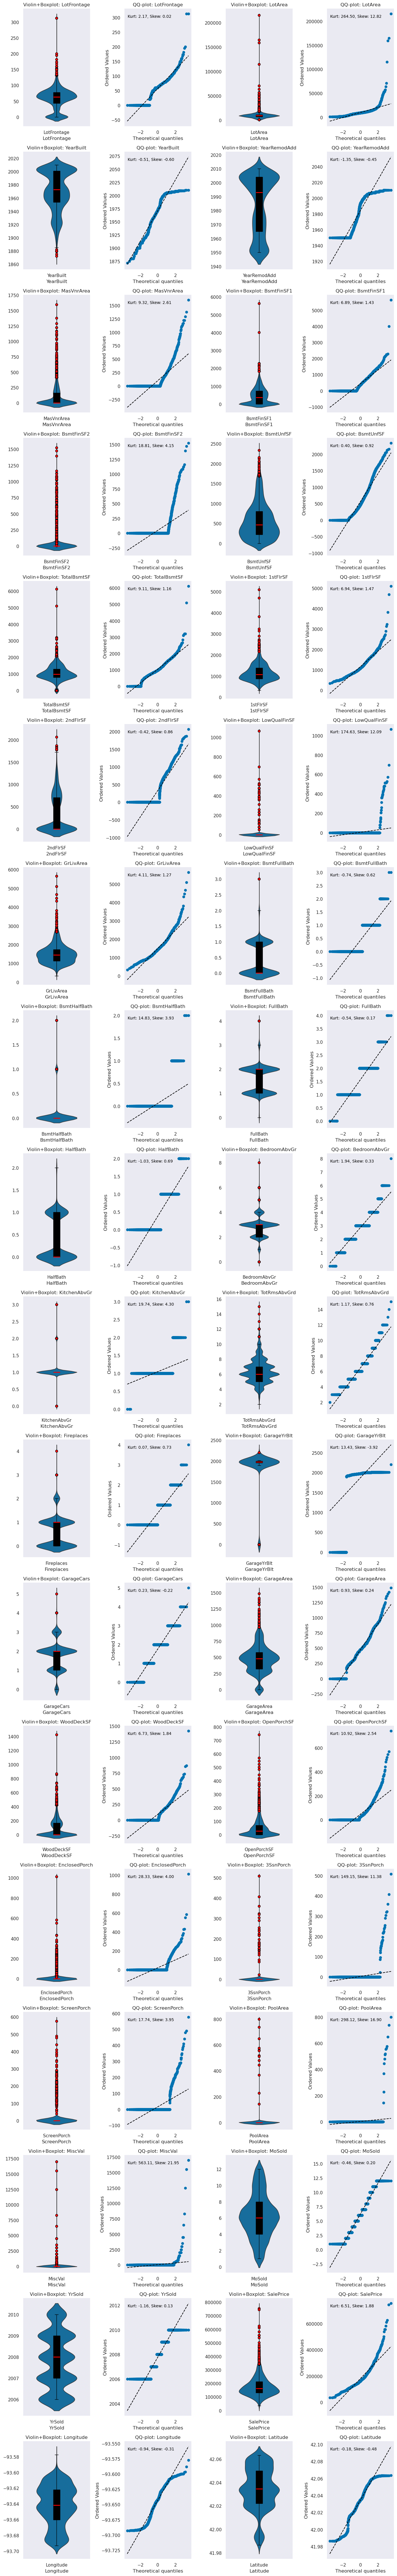

In [76]:
plot_violin_box_qq(df,n_cols_per_row=2)

In [77]:
df.describe()

LotFrontage        LotArea    YearBuilt  YearRemodAdd   MasVnrArea  \
count  2919.000000    2919.000000  2919.000000   2919.000000  2919.000000   
mean     57.766701   10168.114080  1971.312778   1984.264474   101.396026   
std      33.481636    7886.996359    30.291442     20.894344   178.854579   
min       0.000000    1300.000000  1872.000000   1950.000000     0.000000   
25%      43.000000    7478.000000  1953.500000   1965.000000     0.000000   
50%      63.000000    9453.000000  1973.000000   1993.000000     0.000000   
75%      78.000000   11570.000000  2001.000000   2004.000000   163.500000   
max     313.000000  215245.000000  2010.000000   2010.000000  1600.000000   

        BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF  \
count  2919.000000  2919.000000  2919.000000  2919.000000  2919.000000   
mean    441.272011    49.565262   560.579993  1051.417266  1159.581706   
std     455.606014   169.179104   439.590889   441.120498   392.362079   
min       0.000000     0.000000     0.000000     0.000000   334.000000   
25%       0.000000     0.000000   220.000000   793.000000   876.000000   
50%     368.000000     0.000000   467.000000   989.000000  1082.000000   
75%     733.000000     0.000000   805.000000  1302.000000  1387.500000   
max    5644.000000  1526.000000  2336.000000  6110.000000  5095.000000   

          2ndFlrSF  LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath  \
count  2919.000000   2919.000000  2919.000000   2919.000000   2919.000000   
mean    336.483727      4.694416  1500.759849      0.429599      0.061322   
std     428.701456     46.396825   506.051045      0.524676      0.245608   
min       0.000000      0.000000   334.000000      0.000000      0.000000   
25%       0.000000      0.000000  1126.000000      0.000000      0.000000   
50%       0.000000      0.000000  1444.000000      0.000000      0.000000   
75%     704.000000      0.000000  1743.500000      1.000000      0.000000   
max    2065.000000   1064.000000  5642.000000      3.000000      2.000000   

          FullBath     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  \
count  2919.000000  2919.000000   2919.000000   2919.000000   2919.000000   
mean      1.568003     0.380267      2.860226      1.044536      6.451524   
std       0.552969     0.502872      0.822693      0.214462      1.569379   
min       0.000000     0.000000      0.000000      0.000000      2.000000   
25%       1.000000     0.000000      2.000000      1.000000      5.000000   
50%       2.000000     0.000000      3.000000      1.000000      6.000000   
75%       2.000000     1.000000      3.000000      1.000000      7.000000   
max       4.000000     2.000000      8.000000      3.000000     15.000000   

        Fireplaces  GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  \
count  2919.000000  2919.000000  2919.000000  2919.000000  2919.000000   
mean      0.597122  1871.032032     1.766016   472.712573    93.709832   
std       0.646129   448.353244     0.762196   215.535686   126.526589   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000  1957.000000     1.000000   320.000000     0.000000   
50%       1.000000  1977.000000     2.000000   480.000000     0.000000   
75%       1.000000  2001.000000     2.000000   576.000000   168.000000   
max       4.000000  2207.000000     5.000000  1488.000000  1424.000000   

       OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch     PoolArea  \
count  2919.000000    2919.000000  2919.000000  2919.000000  2919.000000   
mean     47.486811      23.098321     2.602261    16.062350     2.251799   
std      67.575493      64.244246    25.188169    56.184365    35.663946   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000000     0.000000     0.000000   
50%      26.000000       0.000000     0.000000     0.000000     0.000000   
75%      70.000000       0.000000     0.000000     0.000000

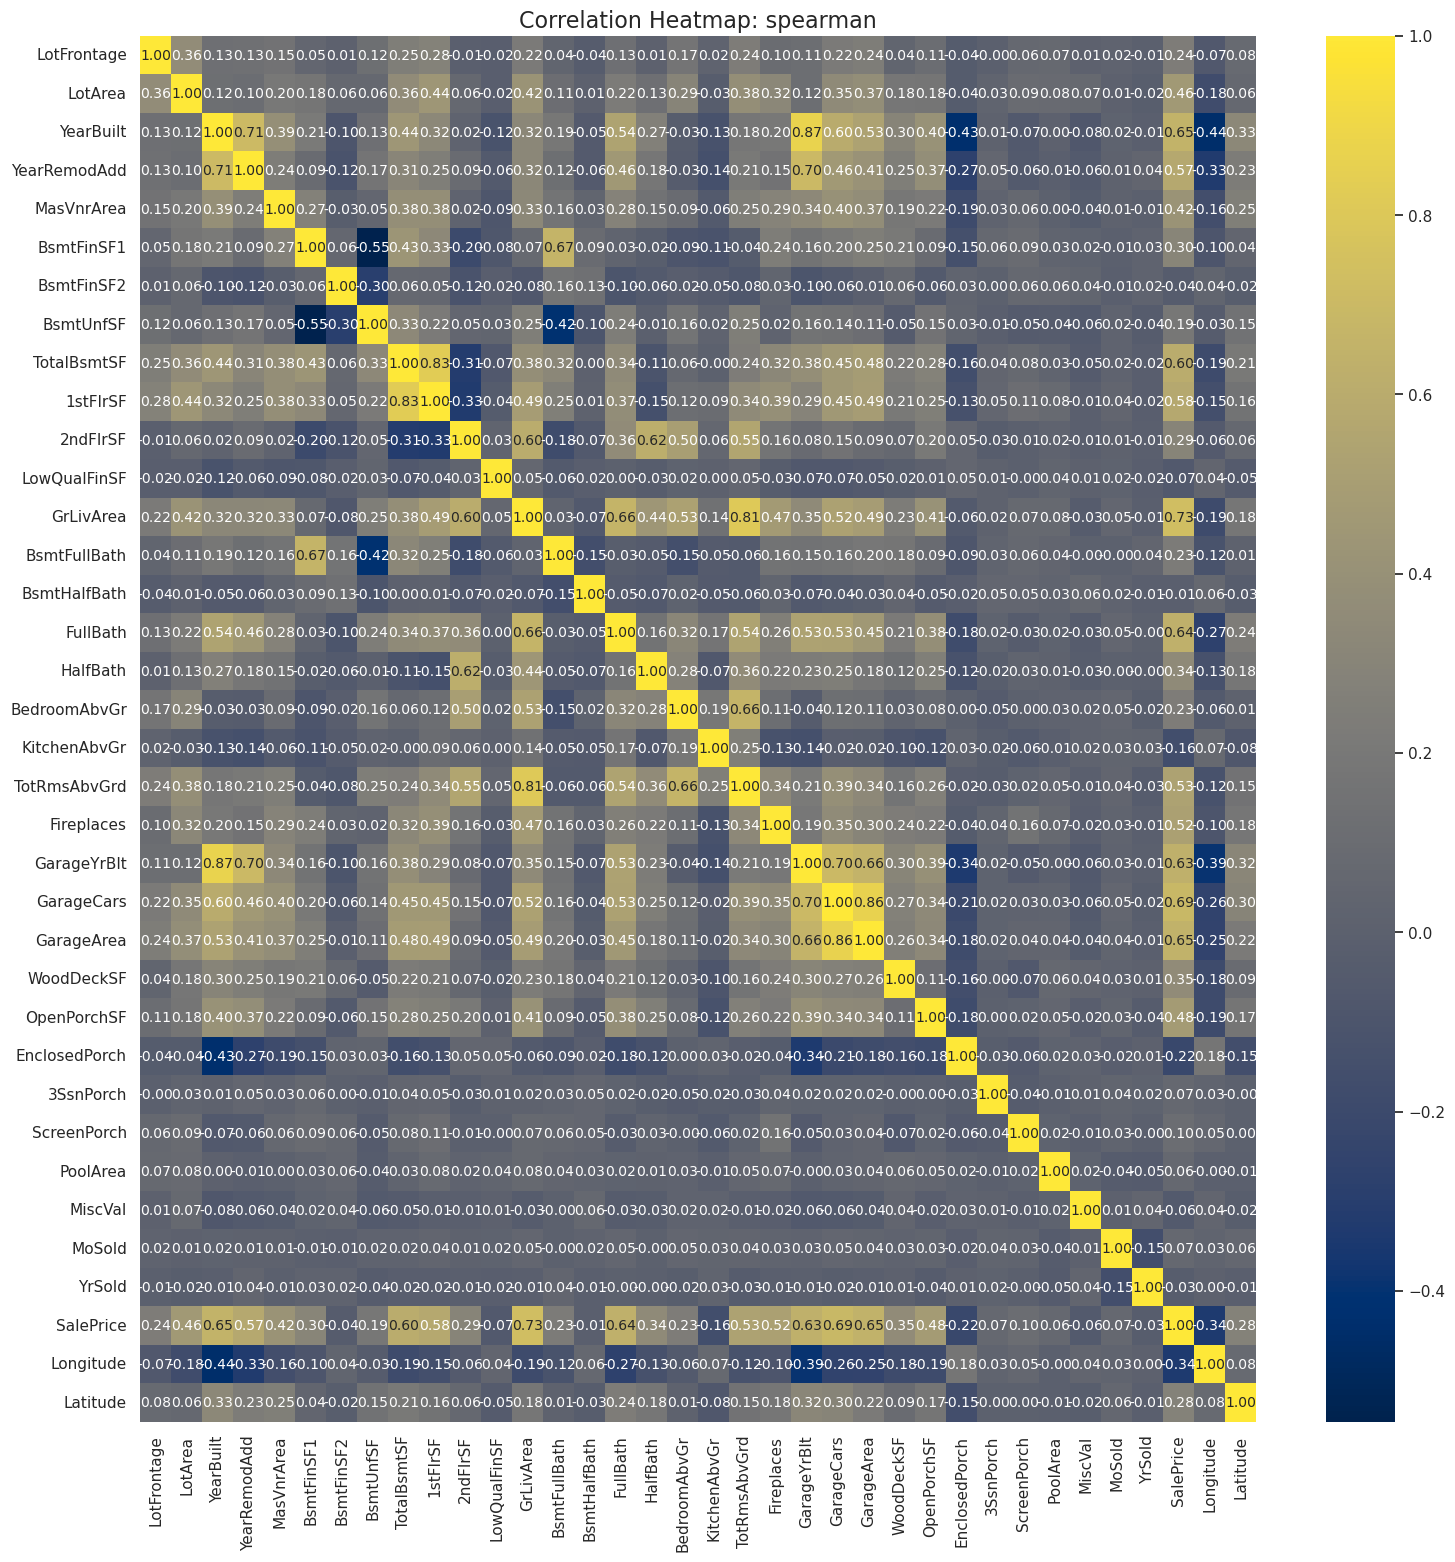

In [78]:
plot_correlation_heatmap(df, cmap=PALETTE, method='spearman', figsize=(18,18)) 

## <span style="color:red">Remarks</span>
- I considered creating 'Built_Sold_delta' and 'Remod_Sold_delta' that represents the diference between 'YearBuilt' and 'YrSold', and 'YearRemodAdd' and 'YrSold', respectively, and 'Built_Remod_delta' that represents the diference between 'YearBuilt' and 'YearRemodAdd', and also 'SeasonSold' representing the season in which the house was sold, but there is no improvement in the predictions.

## Exploring the numeric vs non-numeric features

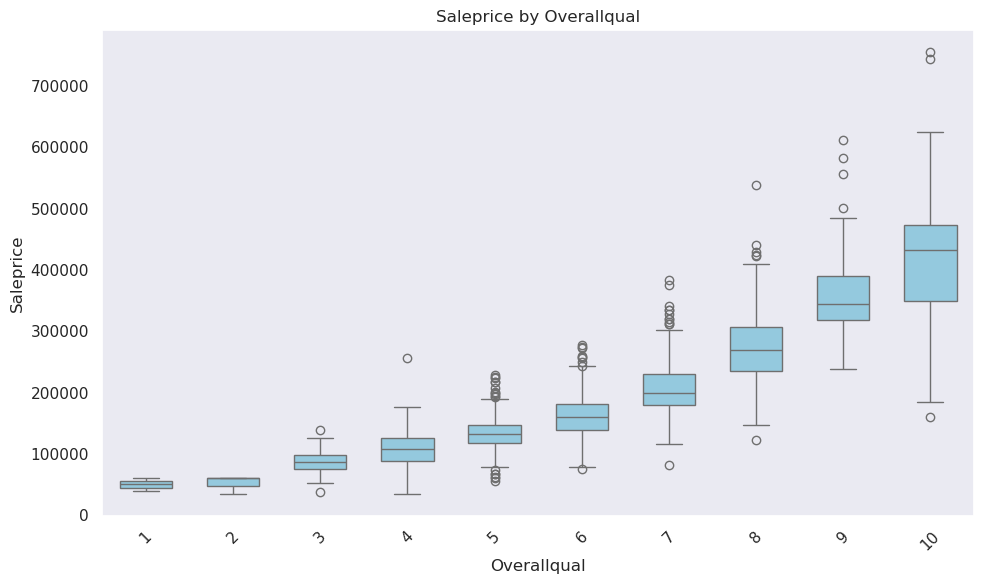

In [81]:
plot_boxplot_cat(df, 'OverallQual', feature_dict['target'],ncols=1)

## <span style="color:red">Thoughts</span>
- given that some ordered features have a clear trend to price, I will explore wether using OrderedIncoder is better than just using OneHotEncoder, as it is the default in AutoGluon (see ah_appendix_02.ipynb)

# Outliers <a name="outliers"></a>

## <span style="color:red">Remarks</span>
I considered that, since the focus is on improving the ability to determine the SalePrice in the test data, it makes sense to remove extreme values from the training dataset. However, this approach did not improve the test dataset score.

- for the record, I will keep the annotated code of the proposed changes to the categorical features below.

In [85]:
# df_train = df.loc[~df['SalePrice'].isnull()]

# feature = 'LotFrontage'
# value_limit = 250
# df.loc[df[feature]>value_limit,'SalePrice']
# df = df.drop(df.loc[df[feature]>value_limit,'SalePrice'].index, axis=0)

# feature = 'LotArea'
# value_limit = 100000
# df.loc[df[feature]>value_limit,'SalePrice']
# df = df.drop(df.loc[df[feature]>value_limit,'SalePrice'].index, axis=0)

# feature = 'MasVnrArea'
# value_limit = 1500
# df.loc[df[feature]>value_limit,'SalePrice']
# df = df.drop(df.loc[df[feature]>value_limit,'SalePrice'].index, axis=0)

# New Feature Based on Location <a name="location"></a>

## <span style="color:red">Actions</span>
- create 'Median_n_Closest_SalePrice': the median house value for the n closest houses from the target house
    - this idea is from: https://nycdatascience.com/blog/student-works/data-visualization-on-the-effect-of-home-renovation-on-price/

## <span style="color:red">Thoughts</span>

- given some clusters of houses with and without prices (see the figure below), a small `n` (e.g., 5) is likely to be less effective than larger `n` values in predicting the `'SalePrice'`.
    - therefore, I will calculate the median based on different `n` values and compare the scores to determine the best option.\
P.S.: For the sake of brevity in this portfolio example, I did not conduct an exhaustive search for the best `n` value.


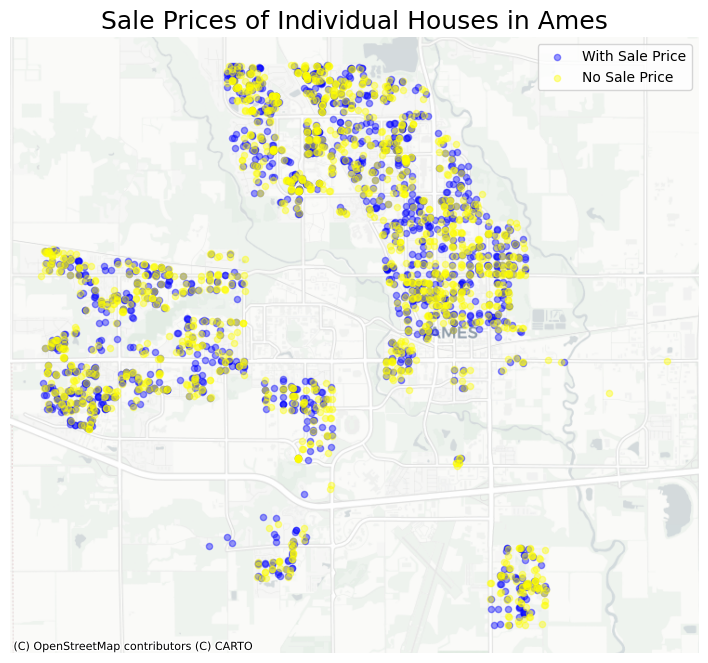

In [88]:
Image(MAP_PRICES_AND_NANS) #map generated in ah_appendix_1

As can be seen in the Figure below, I will adopt the `n` value of 100.

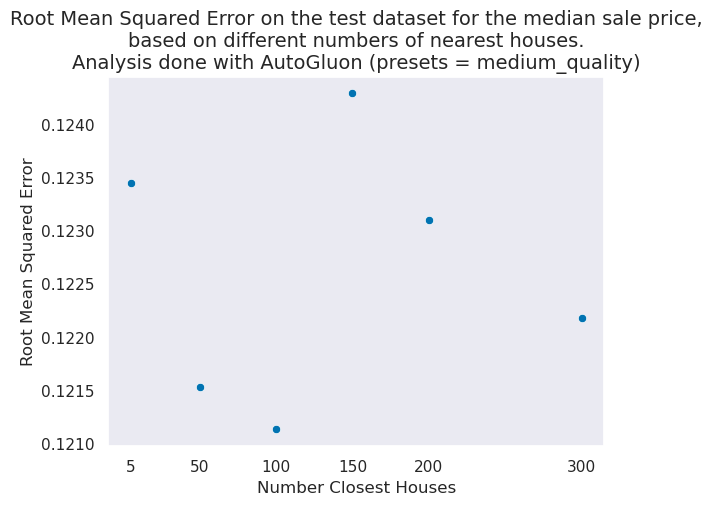

In [90]:
n_median = [5, 50, 100, 200, 300, 150]
score = [0.12345, 0.12153, 0.12113, 0.12310, 0.12218,0.12429]

ax = sns.scatterplot(x=n_median, y=score)

# Adding title and axis labels
ax.set_title('Root Mean Squared Error on the test dataset for the median sale price,\nbased on different numbers of nearest houses.\nAnalysis done with AutoGluon (presets = medium_quality)', fontsize=14)
ax.set_xlabel('Number Closest Houses')
ax.set_ylabel('Root Mean Squared Error')

# Optionally, you can set the x-ticks to the unique values in n_median for exact values
ax.set_xticks(sorted(n_median))  # Set x-axis ticks to exact values of n_median

plt.show()


In [91]:
df = calculate_all_medians(df, n=100)

# New feature based on Economic Data <a name="data"></a>

data retrieved from: https://fred.stlouisfed.org/

## <span style="color:red">Remarks</span>
I considered two indices (S&P CoreLogic Case-Shiller U.S. National Home Price Index and All-Transactions House Price Index for Ames, IA), but neither improved the score
- for the record, I will keep the annotated code of the proposed features below

In [95]:
# ### S&P CoreLogic Case-Shiller U.S. National Home Price Index

# df_case_shiller = pd.read_csv(CASE_SHILLER_DATA)
# df_case_shiller['observation_date'] = pd.to_datetime(df_case_shiller['observation_date'])
# # Filter data between 2006-01-01 and 2010-12-31
# df_case_shiller = df_case_shiller[(df_case_shiller['observation_date'] >= '2006-01-01') & 
#                                 (df_case_shiller['observation_date'] <= '2010-12-31')]

# #create a feature that represent the year and month, to map later into df
# df_case_shiller['map_datetime'] = df_case_shiller['observation_date'].dt.to_period('M').astype(str)

# mapping = df_case_shiller.set_index('map_datetime')['CSUSHPINSA']

# #create the same feature in df
# df['map_datetime'] = df['YrSold'].astype(str) + '-' + df['MoSold'].astype(str).str.zfill(2)
# #add the Case Shiller index in df
# df['case_shiller'] = df['map_datetime'].map(mapping)
# df = df.drop('map_datetime', axis=1)

# ### All-Transactions House Price Index for Ames, IA

# df_house_price_index = pd.read_csv(HOUSE_PRICE_INDEX)
# df_house_price_index['observation_date'] = pd.to_datetime(df_house_price_index['observation_date'])
# # Filter data between 2006-01-01 and 2010-12-31
# df_house_price_index = df_house_price_index[(df_house_price_index['observation_date'] >= '2006-01-01') & 
#                                 (df_house_price_index['observation_date'] <= '2010-12-31')]
# #create a feature that represent the year and month, to map later into df
# df_house_price_index['map_datetime'] = df_house_price_index['observation_date'].dt.to_period('M').astype(str)
# df_house_price_index['map_datetime']

# mapping = df_house_price_index.set_index('map_datetime')['ATNHPIUS11180Q']

# def get_trimester(month):
#     if month in [1, 2, 3]:
#         return 1
#     elif month in [4, 5, 6]:
#         return 4
#     elif month in [7, 8, 9]:
#         return 7
#     elif month in [10, 11, 12]:
#         return 10

# df['trimester'] = df['MoSold'].apply(get_trimester)

# df['map_datetime'] = df['YrSold'].astype(str) + '-' + df['trimester'].astype(str).str.zfill(2)

# df['house_price_index'] = df['map_datetime'].map(mapping)

# df = df.drop(['map_datetime', 'trimester'], axis=1)

In [96]:
sns.scatterplot(x=df['house_price_index'], y=df['case_shiller']);

KeyError: 'house_price_index'

# Saving Cleaned Database <a name="database"></a>

## File Size Optimization

In [98]:
downcast_columns(df)
df.info()
print("\nColumns with null values (%):\n", df.isnull().mean()[lambda x: x > 0].sort_values(ascending=False) * 100)

Column: LotFrontage, All integers: True
Column: LotArea, All integers: True
Column: YearBuilt, All integers: True
Column: YearRemodAdd, All integers: True
Column: MasVnrArea, All integers: True
Column: BsmtFinSF1, All integers: True
Column: BsmtFinSF2, All integers: True
Column: BsmtUnfSF, All integers: True
Column: TotalBsmtSF, All integers: True
Column: 1stFlrSF, All integers: True
Column: 2ndFlrSF, All integers: True
Column: LowQualFinSF, All integers: True
Column: GrLivArea, All integers: True
Column: BsmtFullBath, All integers: True
Column: BsmtHalfBath, All integers: True
Column: FullBath, All integers: True
Column: HalfBath, All integers: True
Column: BedroomAbvGr, All integers: True
Column: KitchenAbvGr, All integers: True
Column: TotRmsAbvGrd, All integers: True
Column: Fireplaces, All integers: True
Column: GarageYrBlt, All integers: False
Column: GarageCars, All integers: True
Column: GarageArea, All integers: True
Column: WoodDeckSF, All integers: True
Column: OpenPorchSF, 

In [100]:
df.to_parquet(CLEAN_DATA,index=False)